##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-10-27 01:21:02.763442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-27 01:21:02.763541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-27 01:21:02.763550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

     8192/228813984 [..............................] - ETA: 0s

  8396800/228813984 [>.............................] - ETA: 1s

 16793600/228813984 [=>............................] - ETA: 1s

 25174016/228813984 [==>...........................] - ETA: 1s

 37199872/228813984 [===>..........................] - ETA: 1s

 50339840/228813984 [=====>........................] - ETA: 1s

 64512000/228813984 [=======>......................] - ETA: 1s

 79519744/228813984 [=========>....................] - ETA: 0s

 94191616/228813984 [===========>..................] - ETA: 0s

110026752/228813984 [=============>................] - ETA: 0s

123699200/228813984 [===============>..............] - ETA: 0s

134225920/228813984 [================>.............] - ETA: 0s

148094976/228813984 [==================>...........] - ETA: 0s

163577856/228813984 [====================>.........] - ETA: 0s

175546368/228813984 [======================>.......] - ETA: 0s

189374464/228813984 [=======================>......] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

214704128/228813984 [===========================>..] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

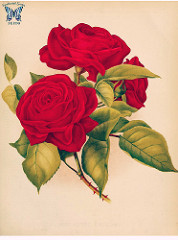

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

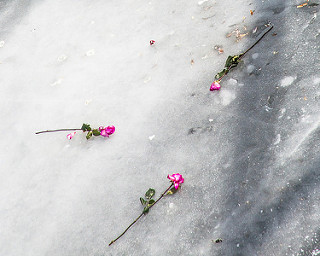

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

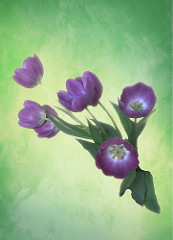

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

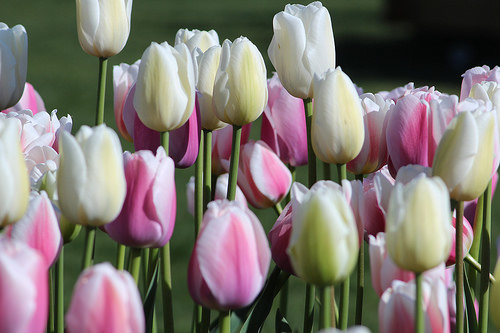

In [8]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

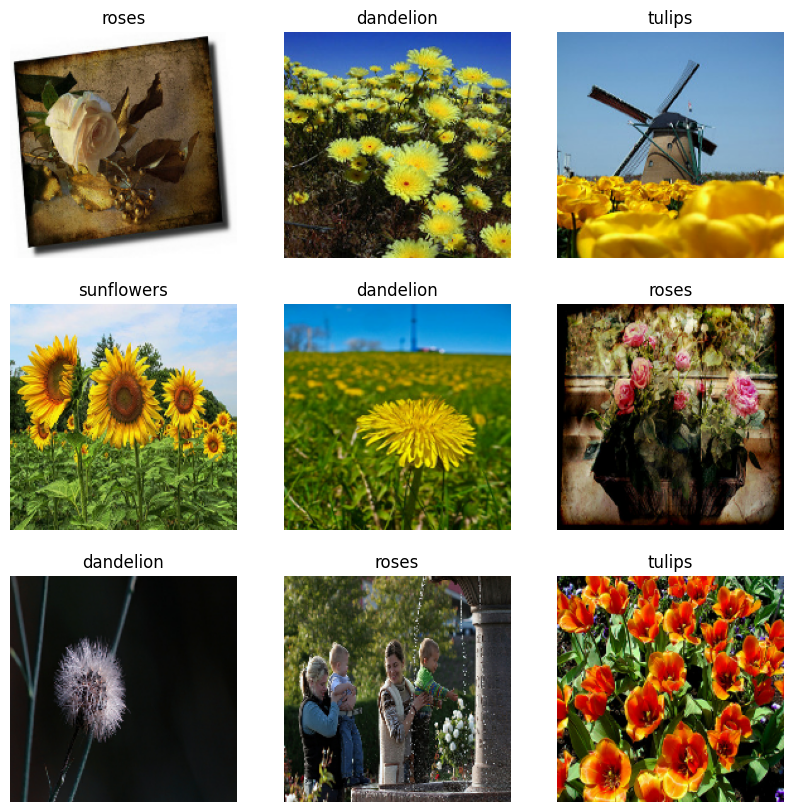

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.9970461


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [20]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d (Conv2D)             (None, 180, 180, 16)      448       


 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 flatten (Flatten)           (None, 30976)             0         


 dense (Dense)               (None, 128)               3965056   


 dense_1 (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 12:57 - loss: 1.6364 - accuracy: 0.1562

 5/92 [>.............................] - ETA: 1s - loss: 1.9896 - accuracy: 0.2375   

 9/92 [=>............................] - ETA: 1s - loss: 1.8264 - accuracy: 0.2396

13/92 [===>..........................] - ETA: 1s - loss: 1.7411 - accuracy: 0.2452

15/92 [===>..........................] - ETA: 1s - loss: 1.7120 - accuracy: 0.2479

19/92 [=====>........................] - ETA: 1s - loss: 1.6676 - accuracy: 0.2650

23/92 [======>.......................] - ETA: 1s - loss: 1.6403 - accuracy: 0.2747

27/92 [=======>......................] - ETA: 1s - loss: 1.6081 - accuracy: 0.2886

31/92 [=========>....................] - ETA: 0s - loss: 1.5697 - accuracy: 0.3110

35/92 [==========>...................] - ETA: 0s - loss: 1.5423 - accuracy: 0.3291

39/92 [===========>..................] - ETA: 0s - loss: 1.5161 - accuracy: 0.3379

43/92 [=============>................] - ETA: 0s - loss: 1.4952 - accuracy: 0.3450

47/92 [==============>...............] - ETA: 0s - loss: 1.4732 - accuracy: 0.3523

51/92 [===============>..............] - ETA: 0s - loss: 1.4529 - accuracy: 0.3621

55/92 [================>.............] - ETA: 0s - loss: 1.4506 - accuracy: 0.3653

59/92 [==================>...........] - ETA: 0s - loss: 1.4293 - accuracy: 0.3755

63/92 [===================>..........] - ETA: 0s - loss: 1.4079 - accuracy: 0.3855

67/92 [====================>.........] - ETA: 0s - loss: 1.3839 - accuracy: 0.4003

71/92 [======================>.......] - ETA: 0s - loss: 1.3638 - accuracy: 0.4117

75/92 [=======================>......] - ETA: 0s - loss: 1.3509 - accuracy: 0.4160

79/92 [========================>.....] - ETA: 0s - loss: 1.3376 - accuracy: 0.4230

83/92 [==========================>...] - ETA: 0s - loss: 1.3270 - accuracy: 0.4309

87/92 [===========================>..] - ETA: 0s - loss: 1.3176 - accuracy: 0.4377

91/92 [============================>.] - ETA: 0s - loss: 1.3137 - accuracy: 0.4390

92/92 [==============================] - 10s 19ms/step - loss: 1.3114 - accuracy: 0.4414 - val_loss: 1.0733 - val_accuracy: 0.5681


Epoch 2/10


 1/92 [..............................] - ETA: 1s - loss: 1.1169 - accuracy: 0.5938

 5/92 [>.............................] - ETA: 1s - loss: 0.9908 - accuracy: 0.6250

 9/92 [=>............................] - ETA: 1s - loss: 1.0431 - accuracy: 0.5868

13/92 [===>..........................] - ETA: 1s - loss: 1.0142 - accuracy: 0.5865

17/92 [====>.........................] - ETA: 1s - loss: 0.9892 - accuracy: 0.6066

21/92 [=====>........................] - ETA: 0s - loss: 1.0134 - accuracy: 0.5923

25/92 [=======>......................] - ETA: 0s - loss: 1.0297 - accuracy: 0.5962

29/92 [========>.....................] - ETA: 0s - loss: 1.0227 - accuracy: 0.5991

33/92 [=========>....................] - ETA: 0s - loss: 1.0153 - accuracy: 0.6051

37/92 [===========>..................] - ETA: 0s - loss: 1.0181 - accuracy: 0.6012

41/92 [============>.................] - ETA: 0s - loss: 1.0120 - accuracy: 0.6066

45/92 [=============>................] - ETA: 0s - loss: 1.0055 - accuracy: 0.6124

49/92 [==============>...............] - ETA: 0s - loss: 1.0057 - accuracy: 0.6128

53/92 [================>.............] - ETA: 0s - loss: 1.0012 - accuracy: 0.6132

57/92 [=================>............] - ETA: 0s - loss: 0.9983 - accuracy: 0.6145

61/92 [==================>...........] - ETA: 0s - loss: 0.9893 - accuracy: 0.6204

65/92 [====================>.........] - ETA: 0s - loss: 0.9843 - accuracy: 0.6221

69/92 [=====================>........] - ETA: 0s - loss: 0.9780 - accuracy: 0.6232

73/92 [======================>.......] - ETA: 0s - loss: 0.9758 - accuracy: 0.6237

77/92 [========================>.....] - ETA: 0s - loss: 0.9769 - accuracy: 0.6238

81/92 [=========================>....] - ETA: 0s - loss: 0.9752 - accuracy: 0.6242

85/92 [==========================>...] - ETA: 0s - loss: 0.9708 - accuracy: 0.6265

89/92 [============================>.] - ETA: 0s - loss: 0.9705 - accuracy: 0.6282

92/92 [==============================] - 1s 16ms/step - loss: 0.9782 - accuracy: 0.6233 - val_loss: 1.0065 - val_accuracy: 0.5954


Epoch 3/10


 1/92 [..............................] - ETA: 1s - loss: 0.7129 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 1s - loss: 0.7998 - accuracy: 0.6687

 9/92 [=>............................] - ETA: 1s - loss: 0.8640 - accuracy: 0.6632

13/92 [===>..........................] - ETA: 1s - loss: 0.8570 - accuracy: 0.6875

17/92 [====>.........................] - ETA: 1s - loss: 0.8658 - accuracy: 0.6857

21/92 [=====>........................] - ETA: 0s - loss: 0.8638 - accuracy: 0.6771

25/92 [=======>......................] - ETA: 0s - loss: 0.8674 - accuracy: 0.6787

29/92 [========>.....................] - ETA: 0s - loss: 0.8772 - accuracy: 0.6681

33/92 [=========>....................] - ETA: 0s - loss: 0.8589 - accuracy: 0.6761

37/92 [===========>..................] - ETA: 0s - loss: 0.8521 - accuracy: 0.6731

41/92 [============>.................] - ETA: 0s - loss: 0.8457 - accuracy: 0.6806

45/92 [=============>................] - ETA: 0s - loss: 0.8462 - accuracy: 0.6785

49/92 [==============>...............] - ETA: 0s - loss: 0.8448 - accuracy: 0.6754

53/92 [================>.............] - ETA: 0s - loss: 0.8424 - accuracy: 0.6763

57/92 [=================>............] - ETA: 0s - loss: 0.8411 - accuracy: 0.6754

61/92 [==================>...........] - ETA: 0s - loss: 0.8340 - accuracy: 0.6798

65/92 [====================>.........] - ETA: 0s - loss: 0.8337 - accuracy: 0.6779

69/92 [=====================>........] - ETA: 0s - loss: 0.8298 - accuracy: 0.6798

73/92 [======================>.......] - ETA: 0s - loss: 0.8300 - accuracy: 0.6811

77/92 [========================>.....] - ETA: 0s - loss: 0.8301 - accuracy: 0.6800

81/92 [=========================>....] - ETA: 0s - loss: 0.8284 - accuracy: 0.6792

85/92 [==========================>...] - ETA: 0s - loss: 0.8277 - accuracy: 0.6788

89/92 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.6792

92/92 [==============================] - 1s 16ms/step - loss: 0.8202 - accuracy: 0.6802 - val_loss: 0.9714 - val_accuracy: 0.6199


Epoch 4/10


 1/92 [..............................] - ETA: 1s - loss: 0.4888 - accuracy: 0.8125

 5/92 [>.............................] - ETA: 1s - loss: 0.6228 - accuracy: 0.7375

 9/92 [=>............................] - ETA: 1s - loss: 0.6244 - accuracy: 0.7465

13/92 [===>..........................] - ETA: 1s - loss: 0.6434 - accuracy: 0.7332

17/92 [====>.........................] - ETA: 1s - loss: 0.6272 - accuracy: 0.7482

21/92 [=====>........................] - ETA: 0s - loss: 0.6381 - accuracy: 0.7560

25/92 [=======>......................] - ETA: 0s - loss: 0.6365 - accuracy: 0.7550

29/92 [========>.....................] - ETA: 0s - loss: 0.6458 - accuracy: 0.7565

33/92 [=========>....................] - ETA: 0s - loss: 0.6378 - accuracy: 0.7623

37/92 [===========>..................] - ETA: 0s - loss: 0.6356 - accuracy: 0.7576

41/92 [============>.................] - ETA: 0s - loss: 0.6293 - accuracy: 0.7622

45/92 [=============>................] - ETA: 0s - loss: 0.6302 - accuracy: 0.7612

49/92 [==============>...............] - ETA: 0s - loss: 0.6143 - accuracy: 0.7699

53/92 [================>.............] - ETA: 0s - loss: 0.6280 - accuracy: 0.7672

57/92 [=================>............] - ETA: 0s - loss: 0.6191 - accuracy: 0.7709

61/92 [==================>...........] - ETA: 0s - loss: 0.6187 - accuracy: 0.7690

65/92 [====================>.........] - ETA: 0s - loss: 0.6245 - accuracy: 0.7669

69/92 [=====================>........] - ETA: 0s - loss: 0.6243 - accuracy: 0.7645

73/92 [======================>.......] - ETA: 0s - loss: 0.6269 - accuracy: 0.7650

77/92 [========================>.....] - ETA: 0s - loss: 0.6286 - accuracy: 0.7655

81/92 [=========================>....] - ETA: 0s - loss: 0.6384 - accuracy: 0.7593

85/92 [==========================>...] - ETA: 0s - loss: 0.6397 - accuracy: 0.7577

89/92 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.7560

92/92 [==============================] - 1s 16ms/step - loss: 0.6437 - accuracy: 0.7558 - val_loss: 0.9029 - val_accuracy: 0.6390


Epoch 5/10


 1/92 [..............................] - ETA: 1s - loss: 0.3349 - accuracy: 0.9375

 5/92 [>.............................] - ETA: 1s - loss: 0.4657 - accuracy: 0.8750

 9/92 [=>............................] - ETA: 1s - loss: 0.4575 - accuracy: 0.8611

13/92 [===>..........................] - ETA: 1s - loss: 0.4545 - accuracy: 0.8558

17/92 [====>.........................] - ETA: 1s - loss: 0.4792 - accuracy: 0.8419

21/92 [=====>........................] - ETA: 0s - loss: 0.4723 - accuracy: 0.8378

25/92 [=======>......................] - ETA: 0s - loss: 0.4612 - accuracy: 0.8400

29/92 [========>.....................] - ETA: 0s - loss: 0.4423 - accuracy: 0.8481

33/92 [=========>....................] - ETA: 0s - loss: 0.4355 - accuracy: 0.8504

37/92 [===========>..................] - ETA: 0s - loss: 0.4227 - accuracy: 0.8564

41/92 [============>.................] - ETA: 0s - loss: 0.4299 - accuracy: 0.8514

45/92 [=============>................] - ETA: 0s - loss: 0.4252 - accuracy: 0.8542

49/92 [==============>...............] - ETA: 0s - loss: 0.4194 - accuracy: 0.8559

53/92 [================>.............] - ETA: 0s - loss: 0.4208 - accuracy: 0.8538

57/92 [=================>............] - ETA: 0s - loss: 0.4258 - accuracy: 0.8503

61/92 [==================>...........] - ETA: 0s - loss: 0.4194 - accuracy: 0.8514

65/92 [====================>.........] - ETA: 0s - loss: 0.4217 - accuracy: 0.8505

69/92 [=====================>........] - ETA: 0s - loss: 0.4173 - accuracy: 0.8510

73/92 [======================>.......] - ETA: 0s - loss: 0.4183 - accuracy: 0.8485

77/92 [========================>.....] - ETA: 0s - loss: 0.4140 - accuracy: 0.8494

81/92 [=========================>....] - ETA: 0s - loss: 0.4142 - accuracy: 0.8472

85/92 [==========================>...] - ETA: 0s - loss: 0.4152 - accuracy: 0.8462

89/92 [============================>.] - ETA: 0s - loss: 0.4154 - accuracy: 0.8454

92/92 [==============================] - 1s 16ms/step - loss: 0.4155 - accuracy: 0.8450 - val_loss: 1.2644 - val_accuracy: 0.5695


Epoch 6/10


 1/92 [..............................] - ETA: 1s - loss: 0.3213 - accuracy: 0.9062

 5/92 [>.............................] - ETA: 1s - loss: 0.2403 - accuracy: 0.9187

 9/92 [=>............................] - ETA: 1s - loss: 0.2302 - accuracy: 0.9375

13/92 [===>..........................] - ETA: 1s - loss: 0.2286 - accuracy: 0.9375

17/92 [====>.........................] - ETA: 1s - loss: 0.2619 - accuracy: 0.9191

21/92 [=====>........................] - ETA: 0s - loss: 0.2626 - accuracy: 0.9167

25/92 [=======>......................] - ETA: 0s - loss: 0.2625 - accuracy: 0.9187

29/92 [========>.....................] - ETA: 0s - loss: 0.2674 - accuracy: 0.9170

33/92 [=========>....................] - ETA: 0s - loss: 0.2630 - accuracy: 0.9186

37/92 [===========>..................] - ETA: 0s - loss: 0.2581 - accuracy: 0.9223

41/92 [============>.................] - ETA: 0s - loss: 0.2590 - accuracy: 0.9207

45/92 [=============>................] - ETA: 0s - loss: 0.2657 - accuracy: 0.9181

49/92 [==============>...............] - ETA: 0s - loss: 0.2656 - accuracy: 0.9171

53/92 [================>.............] - ETA: 0s - loss: 0.2717 - accuracy: 0.9110

57/92 [=================>............] - ETA: 0s - loss: 0.2691 - accuracy: 0.9106

61/92 [==================>...........] - ETA: 0s - loss: 0.2679 - accuracy: 0.9114

65/92 [====================>.........] - ETA: 0s - loss: 0.2765 - accuracy: 0.9072

69/92 [=====================>........] - ETA: 0s - loss: 0.2836 - accuracy: 0.9058

73/92 [======================>.......] - ETA: 0s - loss: 0.2851 - accuracy: 0.9058

77/92 [========================>.....] - ETA: 0s - loss: 0.2882 - accuracy: 0.9042

81/92 [=========================>....] - ETA: 0s - loss: 0.2874 - accuracy: 0.9043

85/92 [==========================>...] - ETA: 0s - loss: 0.2988 - accuracy: 0.9004

89/92 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8986

92/92 [==============================] - 1s 16ms/step - loss: 0.3055 - accuracy: 0.8968 - val_loss: 1.1000 - val_accuracy: 0.6240


Epoch 7/10


 1/92 [..............................] - ETA: 1s - loss: 0.1263 - accuracy: 0.9688

 5/92 [>.............................] - ETA: 1s - loss: 0.1468 - accuracy: 0.9671

 9/92 [=>............................] - ETA: 1s - loss: 0.1442 - accuracy: 0.9679

13/92 [===>..........................] - ETA: 1s - loss: 0.1421 - accuracy: 0.9681

17/92 [====>.........................] - ETA: 1s - loss: 0.1403 - accuracy: 0.9701

21/92 [=====>........................] - ETA: 0s - loss: 0.1512 - accuracy: 0.9654

25/92 [=======>......................] - ETA: 0s - loss: 0.1450 - accuracy: 0.9659

29/92 [========>.....................] - ETA: 0s - loss: 0.1550 - accuracy: 0.9598

33/92 [=========>....................] - ETA: 0s - loss: 0.1491 - accuracy: 0.9609

37/92 [===========>..................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9609

41/92 [============>.................] - ETA: 0s - loss: 0.1504 - accuracy: 0.9601

45/92 [=============>................] - ETA: 0s - loss: 0.1517 - accuracy: 0.9574

49/92 [==============>...............] - ETA: 0s - loss: 0.1478 - accuracy: 0.9590

53/92 [================>.............] - ETA: 0s - loss: 0.1435 - accuracy: 0.9597

57/92 [=================>............] - ETA: 0s - loss: 0.1423 - accuracy: 0.9609

61/92 [==================>...........] - ETA: 0s - loss: 0.1396 - accuracy: 0.9619

65/92 [====================>.........] - ETA: 0s - loss: 0.1392 - accuracy: 0.9624

69/92 [=====================>........] - ETA: 0s - loss: 0.1415 - accuracy: 0.9623

73/92 [======================>.......] - ETA: 0s - loss: 0.1440 - accuracy: 0.9605

77/92 [========================>.....] - ETA: 0s - loss: 0.1425 - accuracy: 0.9605

81/92 [=========================>....] - ETA: 0s - loss: 0.1434 - accuracy: 0.9598

85/92 [==========================>...] - ETA: 0s - loss: 0.1468 - accuracy: 0.9569

89/92 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9553

92/92 [==============================] - 1s 16ms/step - loss: 0.1507 - accuracy: 0.9554 - val_loss: 1.4502 - val_accuracy: 0.5940


Epoch 8/10


 1/92 [..............................] - ETA: 1s - loss: 0.0944 - accuracy: 1.0000

 5/92 [>.............................] - ETA: 1s - loss: 0.1076 - accuracy: 0.9750

 9/92 [=>............................] - ETA: 1s - loss: 0.1104 - accuracy: 0.9688

13/92 [===>..........................] - ETA: 1s - loss: 0.1072 - accuracy: 0.9712

17/92 [====>.........................] - ETA: 1s - loss: 0.1053 - accuracy: 0.9743

21/92 [=====>........................] - ETA: 0s - loss: 0.1055 - accuracy: 0.9747

25/92 [=======>......................] - ETA: 0s - loss: 0.1096 - accuracy: 0.9725

29/92 [========>.....................] - ETA: 0s - loss: 0.1010 - accuracy: 0.9763

33/92 [=========>....................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9773

37/92 [===========>..................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9772

41/92 [============>.................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9779

45/92 [=============>................] - ETA: 0s - loss: 0.0978 - accuracy: 0.9778

49/92 [==============>...............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9783

53/92 [================>.............] - ETA: 0s - loss: 0.0950 - accuracy: 0.9776

57/92 [=================>............] - ETA: 0s - loss: 0.0950 - accuracy: 0.9770

61/92 [==================>...........] - ETA: 0s - loss: 0.0930 - accuracy: 0.9780

65/92 [====================>.........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9779

69/92 [=====================>........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9778

73/92 [======================>.......] - ETA: 0s - loss: 0.0951 - accuracy: 0.9769

77/92 [========================>.....] - ETA: 0s - loss: 0.0937 - accuracy: 0.9773

81/92 [=========================>....] - ETA: 0s - loss: 0.0931 - accuracy: 0.9776

85/92 [==========================>...] - ETA: 0s - loss: 0.0924 - accuracy: 0.9775

89/92 [============================>.] - ETA: 0s - loss: 0.0921 - accuracy: 0.9771

92/92 [==============================] - 1s 15ms/step - loss: 0.0914 - accuracy: 0.9772 - val_loss: 1.4260 - val_accuracy: 0.6376


Epoch 9/10


 1/92 [..............................] - ETA: 1s - loss: 0.0468 - accuracy: 1.0000

 5/92 [>.............................] - ETA: 1s - loss: 0.0319 - accuracy: 0.9937

 9/92 [=>............................] - ETA: 1s - loss: 0.0391 - accuracy: 0.9931

13/92 [===>..........................] - ETA: 1s - loss: 0.0438 - accuracy: 0.9856

17/92 [====>.........................] - ETA: 1s - loss: 0.0402 - accuracy: 0.9871

21/92 [=====>........................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9880

25/92 [=======>......................] - ETA: 0s - loss: 0.0377 - accuracy: 0.9886

29/92 [========>.....................] - ETA: 0s - loss: 0.0362 - accuracy: 0.9902

33/92 [=========>....................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9914

37/92 [===========>..................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9923

41/92 [============>.................] - ETA: 0s - loss: 0.0338 - accuracy: 0.9923

45/92 [=============>................] - ETA: 0s - loss: 0.0361 - accuracy: 0.9916

49/92 [==============>...............] - ETA: 0s - loss: 0.0343 - accuracy: 0.9923

53/92 [================>.............] - ETA: 0s - loss: 0.0336 - accuracy: 0.9929

57/92 [=================>............] - ETA: 0s - loss: 0.0346 - accuracy: 0.9923

61/92 [==================>...........] - ETA: 0s - loss: 0.0371 - accuracy: 0.9913

65/92 [====================>.........] - ETA: 0s - loss: 0.0380 - accuracy: 0.9913

69/92 [=====================>........] - ETA: 0s - loss: 0.0396 - accuracy: 0.9914

73/92 [======================>.......] - ETA: 0s - loss: 0.0392 - accuracy: 0.9918

77/92 [========================>.....] - ETA: 0s - loss: 0.0423 - accuracy: 0.9910

81/92 [=========================>....] - ETA: 0s - loss: 0.0436 - accuracy: 0.9903

85/92 [==========================>...] - ETA: 0s - loss: 0.0471 - accuracy: 0.9889

89/92 [============================>.] - ETA: 0s - loss: 0.0482 - accuracy: 0.9884

92/92 [==============================] - 1s 16ms/step - loss: 0.0491 - accuracy: 0.9884 - val_loss: 1.9028 - val_accuracy: 0.5981


Epoch 10/10


 1/92 [..............................] - ETA: 1s - loss: 0.1228 - accuracy: 0.9375

 5/92 [>.............................] - ETA: 1s - loss: 0.0508 - accuracy: 0.9812

 9/92 [=>............................] - ETA: 1s - loss: 0.0534 - accuracy: 0.9826

13/92 [===>..........................] - ETA: 1s - loss: 0.0470 - accuracy: 0.9856

17/92 [====>.........................] - ETA: 1s - loss: 0.0501 - accuracy: 0.9816

21/92 [=====>........................] - ETA: 0s - loss: 0.0493 - accuracy: 0.9836

25/92 [=======>......................] - ETA: 0s - loss: 0.0567 - accuracy: 0.9825

29/92 [========>.....................] - ETA: 0s - loss: 0.0536 - accuracy: 0.9838

33/92 [=========>....................] - ETA: 0s - loss: 0.0513 - accuracy: 0.9858

37/92 [===========>..................] - ETA: 0s - loss: 0.0510 - accuracy: 0.9848

41/92 [============>.................] - ETA: 0s - loss: 0.0483 - accuracy: 0.9855

45/92 [=============>................] - ETA: 0s - loss: 0.0490 - accuracy: 0.9854

49/92 [==============>...............] - ETA: 0s - loss: 0.0468 - accuracy: 0.9866

53/92 [================>.............] - ETA: 0s - loss: 0.0455 - accuracy: 0.9864

57/92 [=================>............] - ETA: 0s - loss: 0.0441 - accuracy: 0.9868

61/92 [==================>...........] - ETA: 0s - loss: 0.0437 - accuracy: 0.9877

65/92 [====================>.........] - ETA: 0s - loss: 0.0420 - accuracy: 0.9885

69/92 [=====================>........] - ETA: 0s - loss: 0.0429 - accuracy: 0.9877

73/92 [======================>.......] - ETA: 0s - loss: 0.0426 - accuracy: 0.9884

77/92 [========================>.....] - ETA: 0s - loss: 0.0418 - accuracy: 0.9890

81/92 [=========================>....] - ETA: 0s - loss: 0.0423 - accuracy: 0.9888

85/92 [==========================>...] - ETA: 0s - loss: 0.0418 - accuracy: 0.9886

89/92 [============================>.] - ETA: 0s - loss: 0.0428 - accuracy: 0.9880

92/92 [==============================] - 1s 15ms/step - loss: 0.0422 - accuracy: 0.9884 - val_loss: 2.0496 - val_accuracy: 0.6090


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

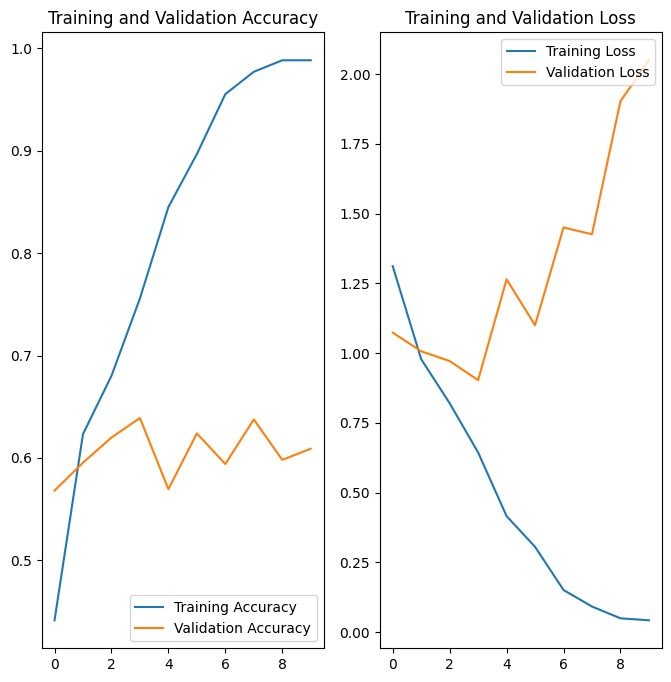

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

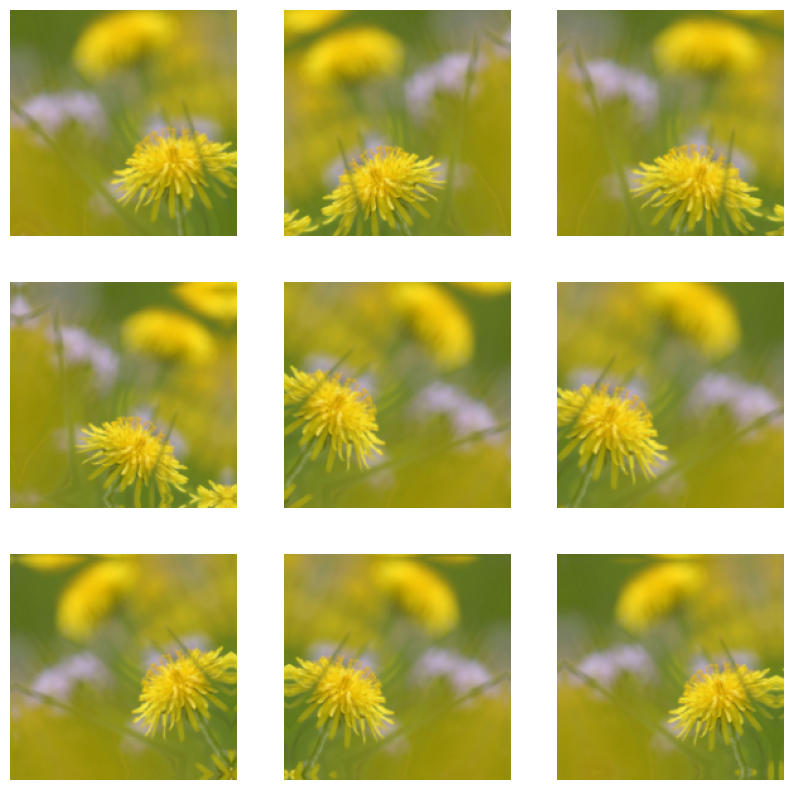

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential_1 (Sequential)   (None, 180, 180, 3)       0         


 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         


 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       


 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      


 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         


 2D)                                                             


 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     


 max_pooling2d_5 (MaxPooling  (None, 22, 22, 64)       0         


 2D)                                                             


 dropout (Dropout)           (None, 22, 22, 64)        0         


 flatten_1 (Flatten)         (None, 30976)             0         


 dense_2 (Dense)             (None, 128)               3965056   


 outputs (Dense)             (None, 5)                 645       


Total params: 3,989,285


Trainable params: 3,989,285


Non-trainable params: 0


_________________________________________________________________


In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-10-27 01:21:51.338790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1/92 [..............................] - ETA: 5:27 - loss: 1.6167 - accuracy: 0.2188

 2/92 [..............................] - ETA: 7s - loss: 1.6305 - accuracy: 0.2344  

 3/92 [..............................] - ETA: 7s - loss: 1.6634 - accuracy: 0.2396

 4/92 [>.............................] - ETA: 7s - loss: 1.6406 - accuracy: 0.2422

 5/92 [>.............................] - ETA: 7s - loss: 1.6417 - accuracy: 0.2562

 6/92 [>.............................] - ETA: 7s - loss: 1.6147 - accuracy: 0.2865

 7/92 [=>............................] - ETA: 7s - loss: 1.6186 - accuracy: 0.2812

 8/92 [=>............................] - ETA: 6s - loss: 1.6275 - accuracy: 0.2695

 9/92 [=>............................] - ETA: 6s - loss: 1.6119 - accuracy: 0.2708

10/92 [==>...........................] - ETA: 6s - loss: 1.6053 - accuracy: 0.2750

11/92 [==>...........................] - ETA: 6s - loss: 1.5971 - accuracy: 0.2841

12/92 [==>...........................] - ETA: 6s - loss: 1.5834 - accuracy: 0.2969

13/92 [===>..........................] - ETA: 6s - loss: 1.5877 - accuracy: 0.2933

14/92 [===>..........................] - ETA: 6s - loss: 1.5762 - accuracy: 0.2991

15/92 [===>..........................] - ETA: 6s - loss: 1.5696 - accuracy: 0.2958

16/92 [====>.........................] - ETA: 6s - loss: 1.5685 - accuracy: 0.2930

17/92 [====>.........................] - ETA: 6s - loss: 1.5655 - accuracy: 0.2886

18/92 [====>.........................] - ETA: 6s - loss: 1.5581 - accuracy: 0.2917

19/92 [=====>........................] - ETA: 6s - loss: 1.5504 - accuracy: 0.2961

20/92 [=====>........................] - ETA: 5s - loss: 1.5354 - accuracy: 0.3094

21/92 [=====>........................] - ETA: 5s - loss: 1.5238 - accuracy: 0.3185

22/92 [======>.......................] - ETA: 5s - loss: 1.5208 - accuracy: 0.3182

23/92 [======>.......................] - ETA: 5s - loss: 1.5154 - accuracy: 0.3193

24/92 [======>.......................] - ETA: 5s - loss: 1.5036 - accuracy: 0.3281

25/92 [=======>......................] - ETA: 5s - loss: 1.4939 - accuracy: 0.3288

26/92 [=======>......................] - ETA: 5s - loss: 1.4928 - accuracy: 0.3305

27/92 [=======>......................] - ETA: 5s - loss: 1.4869 - accuracy: 0.3391

28/92 [========>.....................] - ETA: 5s - loss: 1.4785 - accuracy: 0.3426

29/92 [========>.....................] - ETA: 5s - loss: 1.4696 - accuracy: 0.3459

30/92 [========>.....................] - ETA: 5s - loss: 1.4648 - accuracy: 0.3490

31/92 [=========>....................] - ETA: 5s - loss: 1.4621 - accuracy: 0.3508

32/92 [=========>....................] - ETA: 4s - loss: 1.4533 - accuracy: 0.3573

33/92 [=========>....................] - ETA: 4s - loss: 1.4431 - accuracy: 0.3626

34/92 [==========>...................] - ETA: 4s - loss: 1.4367 - accuracy: 0.3657

35/92 [==========>...................] - ETA: 4s - loss: 1.4338 - accuracy: 0.3669

36/92 [==========>...................] - ETA: 4s - loss: 1.4297 - accuracy: 0.3706

37/92 [===========>..................] - ETA: 4s - loss: 1.4318 - accuracy: 0.3690

38/92 [===========>..................] - ETA: 4s - loss: 1.4226 - accuracy: 0.3750

39/92 [===========>..................] - ETA: 4s - loss: 1.4166 - accuracy: 0.3790

40/92 [============>.................] - ETA: 4s - loss: 1.4142 - accuracy: 0.3836

41/92 [============>.................] - ETA: 4s - loss: 1.4169 - accuracy: 0.3827

42/92 [============>.................] - ETA: 4s - loss: 1.4054 - accuracy: 0.3892

43/92 [=============>................] - ETA: 4s - loss: 1.4001 - accuracy: 0.3947

44/92 [=============>................] - ETA: 3s - loss: 1.3960 - accuracy: 0.3943

45/92 [=============>................] - ETA: 3s - loss: 1.3912 - accuracy: 0.3994

46/92 [==============>...............] - ETA: 3s - loss: 1.3890 - accuracy: 0.3975

47/92 [==============>...............] - ETA: 3s - loss: 1.3837 - accuracy: 0.4024

48/92 [==============>...............] - ETA: 3s - loss: 1.3779 - accuracy: 0.4058

49/92 [==============>...............] - ETA: 3s - loss: 1.3781 - accuracy: 0.4071

50/92 [===============>..............] - ETA: 3s - loss: 1.3737 - accuracy: 0.4095

51/92 [===============>..............] - ETA: 3s - loss: 1.3736 - accuracy: 0.4101

52/92 [===============>..............] - ETA: 3s - loss: 1.3678 - accuracy: 0.4112

53/92 [================>.............] - ETA: 3s - loss: 1.3638 - accuracy: 0.4135

54/92 [================>.............] - ETA: 3s - loss: 1.3614 - accuracy: 0.4163

55/92 [================>.............] - ETA: 3s - loss: 1.3578 - accuracy: 0.4178

56/92 [=================>............] - ETA: 2s - loss: 1.3544 - accuracy: 0.4182

57/92 [=================>............] - ETA: 2s - loss: 1.3555 - accuracy: 0.4180

58/92 [=================>............] - ETA: 2s - loss: 1.3514 - accuracy: 0.4199

59/92 [==================>...........] - ETA: 2s - loss: 1.3469 - accuracy: 0.4234

60/92 [==================>...........] - ETA: 2s - loss: 1.3462 - accuracy: 0.4242

61/92 [==================>...........] - ETA: 2s - loss: 1.3465 - accuracy: 0.4239

62/92 [===================>..........] - ETA: 2s - loss: 1.3431 - accuracy: 0.4241

63/92 [===================>..........] - ETA: 2s - loss: 1.3414 - accuracy: 0.4268

64/92 [===================>..........] - ETA: 2s - loss: 1.3347 - accuracy: 0.4314

65/92 [====================>.........] - ETA: 2s - loss: 1.3330 - accuracy: 0.4353

66/92 [====================>.........] - ETA: 2s - loss: 1.3273 - accuracy: 0.4382

67/92 [====================>.........] - ETA: 2s - loss: 1.3274 - accuracy: 0.4396

68/92 [=====================>........] - ETA: 1s - loss: 1.3258 - accuracy: 0.4387

69/92 [=====================>........] - ETA: 1s - loss: 1.3238 - accuracy: 0.4382

70/92 [=====================>........] - ETA: 1s - loss: 1.3210 - accuracy: 0.4391

71/92 [======================>.......] - ETA: 1s - loss: 1.3192 - accuracy: 0.4395

72/92 [======================>.......] - ETA: 1s - loss: 1.3137 - accuracy: 0.4412

73/92 [======================>.......] - ETA: 1s - loss: 1.3144 - accuracy: 0.4429

74/92 [=======================>......] - ETA: 1s - loss: 1.3180 - accuracy: 0.4411

75/92 [=======================>......] - ETA: 1s - loss: 1.3158 - accuracy: 0.4423

76/92 [=======================>......] - ETA: 1s - loss: 1.3133 - accuracy: 0.4422

77/92 [========================>.....] - ETA: 1s - loss: 1.3136 - accuracy: 0.4442

78/92 [========================>.....] - ETA: 1s - loss: 1.3102 - accuracy: 0.4453

79/92 [========================>.....] - ETA: 1s - loss: 1.3096 - accuracy: 0.4433

80/92 [=========================>....] - ETA: 0s - loss: 1.3080 - accuracy: 0.4447

81/92 [=========================>....] - ETA: 0s - loss: 1.3045 - accuracy: 0.4470

82/92 [=========================>....] - ETA: 0s - loss: 1.3021 - accuracy: 0.4476

83/92 [==========================>...] - ETA: 0s - loss: 1.3025 - accuracy: 0.4471

84/92 [==========================>...] - ETA: 0s - loss: 1.3009 - accuracy: 0.4478

85/92 [==========================>...] - ETA: 0s - loss: 1.2992 - accuracy: 0.4491

86/92 [===========================>..] - ETA: 0s - loss: 1.2970 - accuracy: 0.4497

87/92 [===========================>..] - ETA: 0s - loss: 1.2964 - accuracy: 0.4503

88/92 [===========================>..] - ETA: 0s - loss: 1.2929 - accuracy: 0.4526

89/92 [============================>.] - ETA: 0s - loss: 1.2902 - accuracy: 0.4539

90/92 [============================>.] - ETA: 0s - loss: 1.2873 - accuracy: 0.4565

91/92 [============================>.] - ETA: 0s - loss: 1.2846 - accuracy: 0.4580

92/92 [==============================] - ETA: 0s - loss: 1.2819 - accuracy: 0.4598

92/92 [==============================] - 11s 86ms/step - loss: 1.2819 - accuracy: 0.4598 - val_loss: 1.0469 - val_accuracy: 0.5804


Epoch 2/15


 1/92 [..............................] - ETA: 7s - loss: 0.8329 - accuracy: 0.8125

 2/92 [..............................] - ETA: 7s - loss: 0.8644 - accuracy: 0.7344

 3/92 [..............................] - ETA: 7s - loss: 0.9197 - accuracy: 0.6667

 4/92 [>.............................] - ETA: 6s - loss: 1.0124 - accuracy: 0.6172

 5/92 [>.............................] - ETA: 6s - loss: 1.0380 - accuracy: 0.6000

 6/92 [>.............................] - ETA: 6s - loss: 1.0843 - accuracy: 0.5781

 7/92 [=>............................] - ETA: 6s - loss: 1.0727 - accuracy: 0.5982

 8/92 [=>............................] - ETA: 6s - loss: 1.0727 - accuracy: 0.5820

 9/92 [=>............................] - ETA: 6s - loss: 1.0746 - accuracy: 0.5903

10/92 [==>...........................] - ETA: 6s - loss: 1.0647 - accuracy: 0.5938

11/92 [==>...........................] - ETA: 6s - loss: 1.0690 - accuracy: 0.5930

12/92 [==>...........................] - ETA: 6s - loss: 1.0481 - accuracy: 0.6037

13/92 [===>..........................] - ETA: 6s - loss: 1.0283 - accuracy: 0.6103

14/92 [===>..........................] - ETA: 6s - loss: 1.0170 - accuracy: 0.6136

15/92 [===>..........................] - ETA: 6s - loss: 1.0243 - accuracy: 0.6144

16/92 [====>.........................] - ETA: 6s - loss: 1.0278 - accuracy: 0.6131

17/92 [====>.........................] - ETA: 6s - loss: 1.0261 - accuracy: 0.6119

18/92 [====>.........................] - ETA: 5s - loss: 1.0178 - accuracy: 0.6144

19/92 [=====>........................] - ETA: 5s - loss: 1.0168 - accuracy: 0.6133

20/92 [=====>........................] - ETA: 5s - loss: 1.0153 - accuracy: 0.6092

21/92 [=====>........................] - ETA: 5s - loss: 1.0020 - accuracy: 0.6114

22/92 [======>.......................] - ETA: 5s - loss: 1.0005 - accuracy: 0.6121

23/92 [======>.......................] - ETA: 5s - loss: 0.9965 - accuracy: 0.6140

24/92 [======>.......................] - ETA: 5s - loss: 1.0202 - accuracy: 0.6000

25/92 [=======>......................] - ETA: 5s - loss: 1.0180 - accuracy: 0.5997

26/92 [=======>......................] - ETA: 5s - loss: 1.0228 - accuracy: 0.6007

27/92 [=======>......................] - ETA: 5s - loss: 1.0282 - accuracy: 0.5981

28/92 [========>.....................] - ETA: 5s - loss: 1.0300 - accuracy: 0.5968

29/92 [========>.....................] - ETA: 5s - loss: 1.0238 - accuracy: 0.6000

30/92 [========>.....................] - ETA: 5s - loss: 1.0272 - accuracy: 0.5977

31/92 [=========>....................] - ETA: 4s - loss: 1.0276 - accuracy: 0.5955

32/92 [=========>....................] - ETA: 4s - loss: 1.0260 - accuracy: 0.5945

33/92 [=========>....................] - ETA: 4s - loss: 1.0245 - accuracy: 0.5935

34/92 [==========>...................] - ETA: 4s - loss: 1.0315 - accuracy: 0.5907

35/92 [==========>...................] - ETA: 4s - loss: 1.0350 - accuracy: 0.5908

36/92 [==========>...................] - ETA: 4s - loss: 1.0339 - accuracy: 0.5909

37/92 [===========>..................] - ETA: 4s - loss: 1.0358 - accuracy: 0.5893

38/92 [===========>..................] - ETA: 4s - loss: 1.0384 - accuracy: 0.5886

39/92 [===========>..................] - ETA: 4s - loss: 1.0364 - accuracy: 0.5895

40/92 [============>.................] - ETA: 4s - loss: 1.0335 - accuracy: 0.5896

41/92 [============>.................] - ETA: 4s - loss: 1.0298 - accuracy: 0.5913

42/92 [============>.................] - ETA: 4s - loss: 1.0253 - accuracy: 0.5928

43/92 [=============>................] - ETA: 4s - loss: 1.0248 - accuracy: 0.5936

44/92 [=============>................] - ETA: 3s - loss: 1.0224 - accuracy: 0.5943

45/92 [=============>................] - ETA: 3s - loss: 1.0219 - accuracy: 0.5929

46/92 [==============>...............] - ETA: 3s - loss: 1.0238 - accuracy: 0.5956

47/92 [==============>...............] - ETA: 3s - loss: 1.0234 - accuracy: 0.5943

48/92 [==============>...............] - ETA: 3s - loss: 1.0234 - accuracy: 0.5955

49/92 [==============>...............] - ETA: 3s - loss: 1.0291 - accuracy: 0.5910

50/92 [===============>..............] - ETA: 3s - loss: 1.0362 - accuracy: 0.5886

51/92 [===============>..............] - ETA: 3s - loss: 1.0375 - accuracy: 0.5868

52/92 [===============>..............] - ETA: 3s - loss: 1.0379 - accuracy: 0.5870

53/92 [================>.............] - ETA: 3s - loss: 1.0357 - accuracy: 0.5900

54/92 [================>.............] - ETA: 3s - loss: 1.0326 - accuracy: 0.5907

55/92 [================>.............] - ETA: 3s - loss: 1.0293 - accuracy: 0.5936

56/92 [=================>............] - ETA: 2s - loss: 1.0288 - accuracy: 0.5942

57/92 [=================>............] - ETA: 2s - loss: 1.0260 - accuracy: 0.5958

58/92 [=================>............] - ETA: 2s - loss: 1.0263 - accuracy: 0.5969

59/92 [==================>...........] - ETA: 2s - loss: 1.0266 - accuracy: 0.5968

60/92 [==================>...........] - ETA: 2s - loss: 1.0267 - accuracy: 0.5962

61/92 [==================>...........] - ETA: 2s - loss: 1.0258 - accuracy: 0.5972

62/92 [===================>..........] - ETA: 2s - loss: 1.0268 - accuracy: 0.5972

63/92 [===================>..........] - ETA: 2s - loss: 1.0241 - accuracy: 0.5976

64/92 [===================>..........] - ETA: 2s - loss: 1.0198 - accuracy: 0.6020

65/92 [====================>.........] - ETA: 2s - loss: 1.0173 - accuracy: 0.6042

66/92 [====================>.........] - ETA: 2s - loss: 1.0165 - accuracy: 0.6036

67/92 [====================>.........] - ETA: 2s - loss: 1.0176 - accuracy: 0.6030

68/92 [=====================>........] - ETA: 1s - loss: 1.0174 - accuracy: 0.6033

69/92 [=====================>........] - ETA: 1s - loss: 1.0189 - accuracy: 0.6036

70/92 [=====================>........] - ETA: 1s - loss: 1.0216 - accuracy: 0.6030

71/92 [======================>.......] - ETA: 1s - loss: 1.0204 - accuracy: 0.6029

72/92 [======================>.......] - ETA: 1s - loss: 1.0203 - accuracy: 0.6024

73/92 [======================>.......] - ETA: 1s - loss: 1.0221 - accuracy: 0.6009

74/92 [=======================>......] - ETA: 1s - loss: 1.0192 - accuracy: 0.6017

75/92 [=======================>......] - ETA: 1s - loss: 1.0216 - accuracy: 0.6012

76/92 [=======================>......] - ETA: 1s - loss: 1.0240 - accuracy: 0.6007

77/92 [========================>.....] - ETA: 1s - loss: 1.0222 - accuracy: 0.6018

78/92 [========================>.....] - ETA: 1s - loss: 1.0231 - accuracy: 0.6017

79/92 [========================>.....] - ETA: 1s - loss: 1.0230 - accuracy: 0.6028

80/92 [=========================>....] - ETA: 0s - loss: 1.0233 - accuracy: 0.6015

81/92 [=========================>....] - ETA: 0s - loss: 1.0229 - accuracy: 0.6006

82/92 [=========================>....] - ETA: 0s - loss: 1.0230 - accuracy: 0.6002

83/92 [==========================>...] - ETA: 0s - loss: 1.0255 - accuracy: 0.5997

84/92 [==========================>...] - ETA: 0s - loss: 1.0240 - accuracy: 0.6000

85/92 [==========================>...] - ETA: 0s - loss: 1.0229 - accuracy: 0.6025

86/92 [===========================>..] - ETA: 0s - loss: 1.0248 - accuracy: 0.6020

87/92 [===========================>..] - ETA: 0s - loss: 1.0257 - accuracy: 0.6012

88/92 [===========================>..] - ETA: 0s - loss: 1.0277 - accuracy: 0.6029

89/92 [============================>.] - ETA: 0s - loss: 1.0287 - accuracy: 0.6018

90/92 [============================>.] - ETA: 0s - loss: 1.0297 - accuracy: 0.6017

91/92 [============================>.] - ETA: 0s - loss: 1.0291 - accuracy: 0.6023

92/92 [==============================] - ETA: 0s - loss: 1.0261 - accuracy: 0.6029

92/92 [==============================] - 8s 84ms/step - loss: 1.0261 - accuracy: 0.6029 - val_loss: 0.9627 - val_accuracy: 0.6240


Epoch 3/15


 1/92 [..............................] - ETA: 7s - loss: 0.8609 - accuracy: 0.7500

 2/92 [..............................] - ETA: 7s - loss: 0.8617 - accuracy: 0.7344

 3/92 [..............................] - ETA: 7s - loss: 0.8222 - accuracy: 0.7500

 4/92 [>.............................] - ETA: 7s - loss: 0.8578 - accuracy: 0.7188

 5/92 [>.............................] - ETA: 7s - loss: 0.8640 - accuracy: 0.7125

 6/92 [>.............................] - ETA: 6s - loss: 0.8384 - accuracy: 0.7240

 7/92 [=>............................] - ETA: 6s - loss: 0.8850 - accuracy: 0.6920

 8/92 [=>............................] - ETA: 6s - loss: 0.8999 - accuracy: 0.6797

 9/92 [=>............................] - ETA: 6s - loss: 0.8954 - accuracy: 0.6944

10/92 [==>...........................] - ETA: 6s - loss: 0.8880 - accuracy: 0.6969

11/92 [==>...........................] - ETA: 6s - loss: 0.9036 - accuracy: 0.6847

12/92 [==>...........................] - ETA: 6s - loss: 0.9088 - accuracy: 0.6745

13/92 [===>..........................] - ETA: 6s - loss: 0.9059 - accuracy: 0.6731

14/92 [===>..........................] - ETA: 6s - loss: 0.9108 - accuracy: 0.6786

15/92 [===>..........................] - ETA: 6s - loss: 0.9087 - accuracy: 0.6833

16/92 [====>.........................] - ETA: 6s - loss: 0.9095 - accuracy: 0.6855

17/92 [====>.........................] - ETA: 6s - loss: 0.9123 - accuracy: 0.6783

18/92 [====>.........................] - ETA: 6s - loss: 0.9222 - accuracy: 0.6719

19/92 [=====>........................] - ETA: 5s - loss: 0.9122 - accuracy: 0.6711

20/92 [=====>........................] - ETA: 5s - loss: 0.9362 - accuracy: 0.6578

21/92 [=====>........................] - ETA: 5s - loss: 0.9328 - accuracy: 0.6577

22/92 [======>.......................] - ETA: 5s - loss: 0.9315 - accuracy: 0.6562

23/92 [======>.......................] - ETA: 5s - loss: 0.9389 - accuracy: 0.6467

24/92 [======>.......................] - ETA: 5s - loss: 0.9446 - accuracy: 0.6445

25/92 [=======>......................] - ETA: 5s - loss: 0.9437 - accuracy: 0.6475

26/92 [=======>......................] - ETA: 5s - loss: 0.9527 - accuracy: 0.6454

27/92 [=======>......................] - ETA: 5s - loss: 0.9616 - accuracy: 0.6377

28/92 [========>.....................] - ETA: 5s - loss: 0.9597 - accuracy: 0.6384

29/92 [========>.....................] - ETA: 5s - loss: 0.9560 - accuracy: 0.6412

30/92 [========>.....................] - ETA: 5s - loss: 0.9548 - accuracy: 0.6406

31/92 [=========>....................] - ETA: 4s - loss: 0.9470 - accuracy: 0.6431

32/92 [=========>....................] - ETA: 4s - loss: 0.9423 - accuracy: 0.6436

33/92 [=========>....................] - ETA: 4s - loss: 0.9384 - accuracy: 0.6449

34/92 [==========>...................] - ETA: 4s - loss: 0.9388 - accuracy: 0.6452

35/92 [==========>...................] - ETA: 4s - loss: 0.9345 - accuracy: 0.6473

36/92 [==========>...................] - ETA: 4s - loss: 0.9324 - accuracy: 0.6484

37/92 [===========>..................] - ETA: 4s - loss: 0.9364 - accuracy: 0.6478

38/92 [===========>..................] - ETA: 4s - loss: 0.9334 - accuracy: 0.6497

39/92 [===========>..................] - ETA: 4s - loss: 0.9292 - accuracy: 0.6498

40/92 [============>.................] - ETA: 4s - loss: 0.9309 - accuracy: 0.6477

41/92 [============>.................] - ETA: 4s - loss: 0.9366 - accuracy: 0.6471

42/92 [============>.................] - ETA: 4s - loss: 0.9323 - accuracy: 0.6503

43/92 [=============>................] - ETA: 4s - loss: 0.9338 - accuracy: 0.6497

44/92 [=============>................] - ETA: 3s - loss: 0.9342 - accuracy: 0.6491

45/92 [=============>................] - ETA: 3s - loss: 0.9273 - accuracy: 0.6514

46/92 [==============>...............] - ETA: 3s - loss: 0.9217 - accuracy: 0.6542

47/92 [==============>...............] - ETA: 3s - loss: 0.9194 - accuracy: 0.6556

48/92 [==============>...............] - ETA: 3s - loss: 0.9193 - accuracy: 0.6562

49/92 [==============>...............] - ETA: 3s - loss: 0.9171 - accuracy: 0.6550

50/92 [===============>..............] - ETA: 3s - loss: 0.9205 - accuracy: 0.6531

51/92 [===============>..............] - ETA: 3s - loss: 0.9191 - accuracy: 0.6532

52/92 [===============>..............] - ETA: 3s - loss: 0.9150 - accuracy: 0.6550

53/92 [================>.............] - ETA: 3s - loss: 0.9090 - accuracy: 0.6580

54/92 [================>.............] - ETA: 3s - loss: 0.9084 - accuracy: 0.6586

55/92 [================>.............] - ETA: 3s - loss: 0.9074 - accuracy: 0.6585

56/92 [=================>............] - ETA: 2s - loss: 0.9075 - accuracy: 0.6585

57/92 [=================>............] - ETA: 2s - loss: 0.9068 - accuracy: 0.6584

58/92 [=================>............] - ETA: 2s - loss: 0.9078 - accuracy: 0.6573

59/92 [==================>...........] - ETA: 2s - loss: 0.9109 - accuracy: 0.6525

60/92 [==================>...........] - ETA: 2s - loss: 0.9109 - accuracy: 0.6531

61/92 [==================>...........] - ETA: 2s - loss: 0.9097 - accuracy: 0.6552

62/92 [===================>..........] - ETA: 2s - loss: 0.9095 - accuracy: 0.6557

63/92 [===================>..........] - ETA: 2s - loss: 0.9104 - accuracy: 0.6567

64/92 [===================>..........] - ETA: 2s - loss: 0.9071 - accuracy: 0.6587

65/92 [====================>.........] - ETA: 2s - loss: 0.9039 - accuracy: 0.6596

66/92 [====================>.........] - ETA: 2s - loss: 0.9056 - accuracy: 0.6581

67/92 [====================>.........] - ETA: 2s - loss: 0.9090 - accuracy: 0.6562

68/92 [=====================>........] - ETA: 1s - loss: 0.9136 - accuracy: 0.6544

69/92 [=====================>........] - ETA: 1s - loss: 0.9135 - accuracy: 0.6558

70/92 [=====================>........] - ETA: 1s - loss: 0.9103 - accuracy: 0.6576

71/92 [======================>.......] - ETA: 1s - loss: 0.9102 - accuracy: 0.6567

72/92 [======================>.......] - ETA: 1s - loss: 0.9099 - accuracy: 0.6562

73/92 [======================>.......] - ETA: 1s - loss: 0.9084 - accuracy: 0.6567

74/92 [=======================>......] - ETA: 1s - loss: 0.9085 - accuracy: 0.6562

75/92 [=======================>......] - ETA: 1s - loss: 0.9088 - accuracy: 0.6554

76/92 [=======================>......] - ETA: 1s - loss: 0.9052 - accuracy: 0.6575

77/92 [========================>.....] - ETA: 1s - loss: 0.9059 - accuracy: 0.6575

78/92 [========================>.....] - ETA: 1s - loss: 0.9050 - accuracy: 0.6572

79/92 [========================>.....] - ETA: 1s - loss: 0.9041 - accuracy: 0.6575

80/92 [=========================>....] - ETA: 0s - loss: 0.9074 - accuracy: 0.6560

81/92 [=========================>....] - ETA: 0s - loss: 0.9065 - accuracy: 0.6552

82/92 [=========================>....] - ETA: 0s - loss: 0.9048 - accuracy: 0.6556

83/92 [==========================>...] - ETA: 0s - loss: 0.9062 - accuracy: 0.6541

84/92 [==========================>...] - ETA: 0s - loss: 0.9041 - accuracy: 0.6549

85/92 [==========================>...] - ETA: 0s - loss: 0.9039 - accuracy: 0.6549

86/92 [===========================>..] - ETA: 0s - loss: 0.9009 - accuracy: 0.6560

87/92 [===========================>..] - ETA: 0s - loss: 0.9022 - accuracy: 0.6545

88/92 [===========================>..] - ETA: 0s - loss: 0.9016 - accuracy: 0.6549

89/92 [============================>.] - ETA: 0s - loss: 0.8992 - accuracy: 0.6560

90/92 [============================>.] - ETA: 0s - loss: 0.8999 - accuracy: 0.6553

91/92 [============================>.] - ETA: 0s - loss: 0.8993 - accuracy: 0.6556

92/92 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.6563

92/92 [==============================] - 8s 84ms/step - loss: 0.8992 - accuracy: 0.6563 - val_loss: 0.9083 - val_accuracy: 0.6308


Epoch 4/15


 1/92 [..............................] - ETA: 7s - loss: 0.7112 - accuracy: 0.7812

 2/92 [..............................] - ETA: 6s - loss: 0.7460 - accuracy: 0.7344

 3/92 [..............................] - ETA: 7s - loss: 0.7567 - accuracy: 0.7292

 4/92 [>.............................] - ETA: 7s - loss: 0.7707 - accuracy: 0.7266

 5/92 [>.............................] - ETA: 7s - loss: 0.7990 - accuracy: 0.7125

 6/92 [>.............................] - ETA: 7s - loss: 0.8096 - accuracy: 0.7135

 7/92 [=>............................] - ETA: 7s - loss: 0.7822 - accuracy: 0.7321

 8/92 [=>............................] - ETA: 6s - loss: 0.7614 - accuracy: 0.7461

 9/92 [=>............................] - ETA: 6s - loss: 0.7722 - accuracy: 0.7431

10/92 [==>...........................] - ETA: 6s - loss: 0.7775 - accuracy: 0.7375

11/92 [==>...........................] - ETA: 6s - loss: 0.7964 - accuracy: 0.7273

12/92 [==>...........................] - ETA: 6s - loss: 0.7923 - accuracy: 0.7266

13/92 [===>..........................] - ETA: 6s - loss: 0.7926 - accuracy: 0.7236

14/92 [===>..........................] - ETA: 6s - loss: 0.7892 - accuracy: 0.7210

15/92 [===>..........................] - ETA: 6s - loss: 0.7959 - accuracy: 0.7229

16/92 [====>.........................] - ETA: 6s - loss: 0.7994 - accuracy: 0.7207

17/92 [====>.........................] - ETA: 6s - loss: 0.7885 - accuracy: 0.7243

18/92 [====>.........................] - ETA: 6s - loss: 0.8016 - accuracy: 0.7135

19/92 [=====>........................] - ETA: 6s - loss: 0.8110 - accuracy: 0.7105

20/92 [=====>........................] - ETA: 6s - loss: 0.8004 - accuracy: 0.7109

21/92 [=====>........................] - ETA: 5s - loss: 0.7977 - accuracy: 0.7098

22/92 [======>.......................] - ETA: 5s - loss: 0.8120 - accuracy: 0.7031

23/92 [======>.......................] - ETA: 5s - loss: 0.8215 - accuracy: 0.7011

24/92 [======>.......................] - ETA: 5s - loss: 0.8115 - accuracy: 0.7070

25/92 [=======>......................] - ETA: 5s - loss: 0.8256 - accuracy: 0.7013

26/92 [=======>......................] - ETA: 5s - loss: 0.8357 - accuracy: 0.6983

27/92 [=======>......................] - ETA: 5s - loss: 0.8315 - accuracy: 0.6968

28/92 [========>.....................] - ETA: 5s - loss: 0.8361 - accuracy: 0.6937

29/92 [========>.....................] - ETA: 5s - loss: 0.8351 - accuracy: 0.6935

30/92 [========>.....................] - ETA: 5s - loss: 0.8320 - accuracy: 0.6954

31/92 [=========>....................] - ETA: 5s - loss: 0.8316 - accuracy: 0.6972

32/92 [=========>....................] - ETA: 4s - loss: 0.8347 - accuracy: 0.6988

33/92 [=========>....................] - ETA: 4s - loss: 0.8293 - accuracy: 0.7004

34/92 [==========>...................] - ETA: 4s - loss: 0.8335 - accuracy: 0.6972

35/92 [==========>...................] - ETA: 4s - loss: 0.8317 - accuracy: 0.6978

36/92 [==========>...................] - ETA: 4s - loss: 0.8284 - accuracy: 0.6993

37/92 [===========>..................] - ETA: 4s - loss: 0.8243 - accuracy: 0.7007

38/92 [===========>..................] - ETA: 4s - loss: 0.8266 - accuracy: 0.7012

39/92 [===========>..................] - ETA: 4s - loss: 0.8321 - accuracy: 0.6992

40/92 [============>.................] - ETA: 4s - loss: 0.8283 - accuracy: 0.6997

41/92 [============>.................] - ETA: 4s - loss: 0.8224 - accuracy: 0.7009

42/92 [============>.................] - ETA: 4s - loss: 0.8203 - accuracy: 0.7021

43/92 [=============>................] - ETA: 4s - loss: 0.8235 - accuracy: 0.7010

44/92 [=============>................] - ETA: 3s - loss: 0.8217 - accuracy: 0.7050

45/92 [=============>................] - ETA: 3s - loss: 0.8229 - accuracy: 0.7039

46/92 [==============>...............] - ETA: 3s - loss: 0.8197 - accuracy: 0.7049

47/92 [==============>...............] - ETA: 3s - loss: 0.8218 - accuracy: 0.7039

48/92 [==============>...............] - ETA: 3s - loss: 0.8243 - accuracy: 0.7016

49/92 [==============>...............] - ETA: 3s - loss: 0.8235 - accuracy: 0.7019

50/92 [===============>..............] - ETA: 3s - loss: 0.8249 - accuracy: 0.7023

51/92 [===============>..............] - ETA: 3s - loss: 0.8221 - accuracy: 0.7038

52/92 [===============>..............] - ETA: 3s - loss: 0.8216 - accuracy: 0.7035

53/92 [================>.............] - ETA: 3s - loss: 0.8200 - accuracy: 0.7032

54/92 [================>.............] - ETA: 3s - loss: 0.8238 - accuracy: 0.7012

55/92 [================>.............] - ETA: 3s - loss: 0.8235 - accuracy: 0.7021

56/92 [=================>............] - ETA: 2s - loss: 0.8250 - accuracy: 0.7012

57/92 [=================>............] - ETA: 2s - loss: 0.8253 - accuracy: 0.7015

58/92 [=================>............] - ETA: 2s - loss: 0.8253 - accuracy: 0.7008

59/92 [==================>...........] - ETA: 2s - loss: 0.8257 - accuracy: 0.6995

60/92 [==================>...........] - ETA: 2s - loss: 0.8317 - accuracy: 0.6977

61/92 [==================>...........] - ETA: 2s - loss: 0.8288 - accuracy: 0.6996

62/92 [===================>..........] - ETA: 2s - loss: 0.8283 - accuracy: 0.6994

63/92 [===================>..........] - ETA: 2s - loss: 0.8289 - accuracy: 0.6987

64/92 [===================>..........] - ETA: 2s - loss: 0.8298 - accuracy: 0.6975

65/92 [====================>.........] - ETA: 2s - loss: 0.8310 - accuracy: 0.6969

66/92 [====================>.........] - ETA: 2s - loss: 0.8275 - accuracy: 0.6982

67/92 [====================>.........] - ETA: 2s - loss: 0.8221 - accuracy: 0.7008

68/92 [=====================>........] - ETA: 1s - loss: 0.8222 - accuracy: 0.7006

69/92 [=====================>........] - ETA: 1s - loss: 0.8251 - accuracy: 0.7000

70/92 [=====================>........] - ETA: 1s - loss: 0.8247 - accuracy: 0.6998

71/92 [======================>.......] - ETA: 1s - loss: 0.8278 - accuracy: 0.6983

72/92 [======================>.......] - ETA: 1s - loss: 0.8249 - accuracy: 0.6990

73/92 [======================>.......] - ETA: 1s - loss: 0.8243 - accuracy: 0.6997

74/92 [=======================>......] - ETA: 1s - loss: 0.8249 - accuracy: 0.7000

75/92 [=======================>......] - ETA: 1s - loss: 0.8238 - accuracy: 0.7003

76/92 [=======================>......] - ETA: 1s - loss: 0.8198 - accuracy: 0.7017

77/92 [========================>.....] - ETA: 1s - loss: 0.8222 - accuracy: 0.7011

78/92 [========================>.....] - ETA: 1s - loss: 0.8252 - accuracy: 0.7002

79/92 [========================>.....] - ETA: 1s - loss: 0.8256 - accuracy: 0.7004

80/92 [=========================>....] - ETA: 0s - loss: 0.8263 - accuracy: 0.6995

81/92 [=========================>....] - ETA: 0s - loss: 0.8247 - accuracy: 0.6997

82/92 [=========================>....] - ETA: 0s - loss: 0.8239 - accuracy: 0.7003

83/92 [==========================>...] - ETA: 0s - loss: 0.8292 - accuracy: 0.6983

84/92 [==========================>...] - ETA: 0s - loss: 0.8278 - accuracy: 0.6996

85/92 [==========================>...] - ETA: 0s - loss: 0.8257 - accuracy: 0.7017

86/92 [===========================>..] - ETA: 0s - loss: 0.8278 - accuracy: 0.7001

87/92 [===========================>..] - ETA: 0s - loss: 0.8256 - accuracy: 0.7010

88/92 [===========================>..] - ETA: 0s - loss: 0.8249 - accuracy: 0.7009

89/92 [============================>.] - ETA: 0s - loss: 0.8264 - accuracy: 0.7000

90/92 [============================>.] - ETA: 0s - loss: 0.8253 - accuracy: 0.7013

91/92 [============================>.] - ETA: 0s - loss: 0.8246 - accuracy: 0.7004

92/92 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.7010

92/92 [==============================] - 8s 85ms/step - loss: 0.8223 - accuracy: 0.7010 - val_loss: 0.9381 - val_accuracy: 0.6662


Epoch 5/15


 1/92 [..............................] - ETA: 7s - loss: 0.6348 - accuracy: 0.7188

 2/92 [..............................] - ETA: 7s - loss: 0.6355 - accuracy: 0.7812

 3/92 [..............................] - ETA: 7s - loss: 0.7215 - accuracy: 0.7396

 4/92 [>.............................] - ETA: 7s - loss: 0.7307 - accuracy: 0.7344

 5/92 [>.............................] - ETA: 7s - loss: 0.7657 - accuracy: 0.7000

 6/92 [>.............................] - ETA: 7s - loss: 0.7705 - accuracy: 0.6823

 7/92 [=>............................] - ETA: 7s - loss: 0.7683 - accuracy: 0.6875

 8/92 [=>............................] - ETA: 7s - loss: 0.7564 - accuracy: 0.6914

 9/92 [=>............................] - ETA: 7s - loss: 0.7574 - accuracy: 0.6979

10/92 [==>...........................] - ETA: 7s - loss: 0.7534 - accuracy: 0.7031

11/92 [==>...........................] - ETA: 6s - loss: 0.7491 - accuracy: 0.7045

12/92 [==>...........................] - ETA: 6s - loss: 0.7426 - accuracy: 0.7109

13/92 [===>..........................] - ETA: 6s - loss: 0.7496 - accuracy: 0.7091

14/92 [===>..........................] - ETA: 6s - loss: 0.7679 - accuracy: 0.7031

15/92 [===>..........................] - ETA: 6s - loss: 0.7602 - accuracy: 0.7000

16/92 [====>.........................] - ETA: 6s - loss: 0.7412 - accuracy: 0.7109

17/92 [====>.........................] - ETA: 6s - loss: 0.7336 - accuracy: 0.7114

18/92 [====>.........................] - ETA: 6s - loss: 0.7218 - accuracy: 0.7135

19/92 [=====>........................] - ETA: 6s - loss: 0.7269 - accuracy: 0.7089

20/92 [=====>........................] - ETA: 6s - loss: 0.7246 - accuracy: 0.7094

21/92 [=====>........................] - ETA: 6s - loss: 0.7315 - accuracy: 0.7068

22/92 [======>.......................] - ETA: 5s - loss: 0.7373 - accuracy: 0.7060

23/92 [======>.......................] - ETA: 5s - loss: 0.7392 - accuracy: 0.7065

24/92 [======>.......................] - ETA: 5s - loss: 0.7379 - accuracy: 0.7070

25/92 [=======>......................] - ETA: 5s - loss: 0.7407 - accuracy: 0.7050

26/92 [=======>......................] - ETA: 5s - loss: 0.7374 - accuracy: 0.7079

27/92 [=======>......................] - ETA: 5s - loss: 0.7388 - accuracy: 0.7072

28/92 [========>.....................] - ETA: 5s - loss: 0.7407 - accuracy: 0.7065

29/92 [========>.....................] - ETA: 5s - loss: 0.7441 - accuracy: 0.7058

30/92 [========>.....................] - ETA: 5s - loss: 0.7444 - accuracy: 0.7052

31/92 [=========>....................] - ETA: 5s - loss: 0.7410 - accuracy: 0.7077

32/92 [=========>....................] - ETA: 5s - loss: 0.7520 - accuracy: 0.7080

33/92 [=========>....................] - ETA: 5s - loss: 0.7492 - accuracy: 0.7074

34/92 [==========>...................] - ETA: 4s - loss: 0.7439 - accuracy: 0.7105

35/92 [==========>...................] - ETA: 4s - loss: 0.7427 - accuracy: 0.7116

36/92 [==========>...................] - ETA: 4s - loss: 0.7378 - accuracy: 0.7144

37/92 [===========>..................] - ETA: 4s - loss: 0.7412 - accuracy: 0.7145

38/92 [===========>..................] - ETA: 4s - loss: 0.7370 - accuracy: 0.7171

39/92 [===========>..................] - ETA: 4s - loss: 0.7373 - accuracy: 0.7179

40/92 [============>.................] - ETA: 4s - loss: 0.7369 - accuracy: 0.7188

41/92 [============>.................] - ETA: 4s - loss: 0.7375 - accuracy: 0.7157

42/92 [============>.................] - ETA: 4s - loss: 0.7423 - accuracy: 0.7128

43/92 [=============>................] - ETA: 4s - loss: 0.7456 - accuracy: 0.7086

44/92 [=============>................] - ETA: 4s - loss: 0.7485 - accuracy: 0.7067

45/92 [=============>................] - ETA: 3s - loss: 0.7606 - accuracy: 0.7007

46/92 [==============>...............] - ETA: 3s - loss: 0.7554 - accuracy: 0.7031

47/92 [==============>...............] - ETA: 3s - loss: 0.7513 - accuracy: 0.7055

48/92 [==============>...............] - ETA: 3s - loss: 0.7490 - accuracy: 0.7070

49/92 [==============>...............] - ETA: 3s - loss: 0.7525 - accuracy: 0.7054

50/92 [===============>..............] - ETA: 3s - loss: 0.7528 - accuracy: 0.7069

51/92 [===============>..............] - ETA: 3s - loss: 0.7525 - accuracy: 0.7071

52/92 [===============>..............] - ETA: 3s - loss: 0.7555 - accuracy: 0.7049

53/92 [================>.............] - ETA: 3s - loss: 0.7561 - accuracy: 0.7052

54/92 [================>.............] - ETA: 3s - loss: 0.7568 - accuracy: 0.7049

55/92 [================>.............] - ETA: 3s - loss: 0.7549 - accuracy: 0.7063

56/92 [=================>............] - ETA: 3s - loss: 0.7581 - accuracy: 0.7048

57/92 [=================>............] - ETA: 2s - loss: 0.7565 - accuracy: 0.7056

58/92 [=================>............] - ETA: 2s - loss: 0.7548 - accuracy: 0.7053

59/92 [==================>...........] - ETA: 2s - loss: 0.7554 - accuracy: 0.7050

60/92 [==================>...........] - ETA: 2s - loss: 0.7544 - accuracy: 0.7042

61/92 [==================>...........] - ETA: 2s - loss: 0.7567 - accuracy: 0.7039

62/92 [===================>..........] - ETA: 2s - loss: 0.7577 - accuracy: 0.7031

63/92 [===================>..........] - ETA: 2s - loss: 0.7608 - accuracy: 0.7019

64/92 [===================>..........] - ETA: 2s - loss: 0.7612 - accuracy: 0.7002

65/92 [====================>.........] - ETA: 2s - loss: 0.7656 - accuracy: 0.6986

66/92 [====================>.........] - ETA: 2s - loss: 0.7676 - accuracy: 0.6974

67/92 [====================>.........] - ETA: 2s - loss: 0.7648 - accuracy: 0.6982

68/92 [=====================>........] - ETA: 2s - loss: 0.7654 - accuracy: 0.6972

69/92 [=====================>........] - ETA: 1s - loss: 0.7657 - accuracy: 0.6966

70/92 [=====================>........] - ETA: 1s - loss: 0.7629 - accuracy: 0.6991

71/92 [======================>.......] - ETA: 1s - loss: 0.7626 - accuracy: 0.6994

72/92 [======================>.......] - ETA: 1s - loss: 0.7706 - accuracy: 0.6953

73/92 [======================>.......] - ETA: 1s - loss: 0.7743 - accuracy: 0.6935

74/92 [=======================>......] - ETA: 1s - loss: 0.7763 - accuracy: 0.6930

75/92 [=======================>......] - ETA: 1s - loss: 0.7798 - accuracy: 0.6933

76/92 [=======================>......] - ETA: 1s - loss: 0.7801 - accuracy: 0.6924

77/92 [========================>.....] - ETA: 1s - loss: 0.7787 - accuracy: 0.6940

78/92 [========================>.....] - ETA: 1s - loss: 0.7784 - accuracy: 0.6941

79/92 [========================>.....] - ETA: 1s - loss: 0.7776 - accuracy: 0.6952

80/92 [=========================>....] - ETA: 0s - loss: 0.7765 - accuracy: 0.6955

81/92 [=========================>....] - ETA: 0s - loss: 0.7745 - accuracy: 0.6966

82/92 [=========================>....] - ETA: 0s - loss: 0.7764 - accuracy: 0.6961

83/92 [==========================>...] - ETA: 0s - loss: 0.7769 - accuracy: 0.6968

84/92 [==========================>...] - ETA: 0s - loss: 0.7766 - accuracy: 0.6978

85/92 [==========================>...] - ETA: 0s - loss: 0.7772 - accuracy: 0.6987

86/92 [===========================>..] - ETA: 0s - loss: 0.7783 - accuracy: 0.6983

87/92 [===========================>..] - ETA: 0s - loss: 0.7792 - accuracy: 0.6981

88/92 [===========================>..] - ETA: 0s - loss: 0.7796 - accuracy: 0.6980

89/92 [============================>.] - ETA: 0s - loss: 0.7825 - accuracy: 0.6968

90/92 [============================>.] - ETA: 0s - loss: 0.7830 - accuracy: 0.6964

91/92 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.6977

92/92 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.6972

92/92 [==============================] - 8s 85ms/step - loss: 0.7830 - accuracy: 0.6972 - val_loss: 0.8087 - val_accuracy: 0.6839


Epoch 6/15


 1/92 [..............................] - ETA: 7s - loss: 0.7160 - accuracy: 0.7500

 2/92 [..............................] - ETA: 7s - loss: 0.6471 - accuracy: 0.7656

 3/92 [..............................] - ETA: 7s - loss: 0.6094 - accuracy: 0.8021

 4/92 [>.............................] - ETA: 6s - loss: 0.6431 - accuracy: 0.7734

 5/92 [>.............................] - ETA: 6s - loss: 0.6514 - accuracy: 0.7625

 6/92 [>.............................] - ETA: 6s - loss: 0.6318 - accuracy: 0.7708

 7/92 [=>............................] - ETA: 6s - loss: 0.6444 - accuracy: 0.7500

 8/92 [=>............................] - ETA: 6s - loss: 0.6517 - accuracy: 0.7422

 9/92 [=>............................] - ETA: 6s - loss: 0.6534 - accuracy: 0.7326

10/92 [==>...........................] - ETA: 6s - loss: 0.6459 - accuracy: 0.7406

11/92 [==>...........................] - ETA: 6s - loss: 0.6402 - accuracy: 0.7443

12/92 [==>...........................] - ETA: 6s - loss: 0.6424 - accuracy: 0.7474

13/92 [===>..........................] - ETA: 6s - loss: 0.6438 - accuracy: 0.7476

14/92 [===>..........................] - ETA: 6s - loss: 0.6474 - accuracy: 0.7522

15/92 [===>..........................] - ETA: 6s - loss: 0.6345 - accuracy: 0.7583

16/92 [====>.........................] - ETA: 6s - loss: 0.6497 - accuracy: 0.7461

17/92 [====>.........................] - ETA: 5s - loss: 0.6341 - accuracy: 0.7574

18/92 [====>.........................] - ETA: 5s - loss: 0.6284 - accuracy: 0.7622

19/92 [=====>........................] - ETA: 5s - loss: 0.6280 - accuracy: 0.7615

20/92 [=====>........................] - ETA: 5s - loss: 0.6346 - accuracy: 0.7578

21/92 [=====>........................] - ETA: 5s - loss: 0.6437 - accuracy: 0.7530

22/92 [======>.......................] - ETA: 5s - loss: 0.6381 - accuracy: 0.7528

23/92 [======>.......................] - ETA: 5s - loss: 0.6351 - accuracy: 0.7527

24/92 [======>.......................] - ETA: 5s - loss: 0.6416 - accuracy: 0.7526

25/92 [=======>......................] - ETA: 5s - loss: 0.6410 - accuracy: 0.7525

26/92 [=======>......................] - ETA: 5s - loss: 0.6420 - accuracy: 0.7536

27/92 [=======>......................] - ETA: 5s - loss: 0.6481 - accuracy: 0.7558

28/92 [========>.....................] - ETA: 5s - loss: 0.6519 - accuracy: 0.7556

29/92 [========>.....................] - ETA: 5s - loss: 0.6568 - accuracy: 0.7511

30/92 [========>.....................] - ETA: 5s - loss: 0.6607 - accuracy: 0.7542

31/92 [=========>....................] - ETA: 4s - loss: 0.6631 - accuracy: 0.7540

32/92 [=========>....................] - ETA: 4s - loss: 0.6683 - accuracy: 0.7510

33/92 [=========>....................] - ETA: 4s - loss: 0.6736 - accuracy: 0.7509

34/92 [==========>...................] - ETA: 4s - loss: 0.6708 - accuracy: 0.7509

35/92 [==========>...................] - ETA: 4s - loss: 0.6746 - accuracy: 0.7491

36/92 [==========>...................] - ETA: 4s - loss: 0.6756 - accuracy: 0.7491

37/92 [===========>..................] - ETA: 4s - loss: 0.6803 - accuracy: 0.7449

38/92 [===========>..................] - ETA: 4s - loss: 0.6841 - accuracy: 0.7434

39/92 [===========>..................] - ETA: 4s - loss: 0.6829 - accuracy: 0.7452

40/92 [============>.................] - ETA: 4s - loss: 0.6845 - accuracy: 0.7461

41/92 [============>.................] - ETA: 4s - loss: 0.6826 - accuracy: 0.7470

42/92 [============>.................] - ETA: 4s - loss: 0.6809 - accuracy: 0.7485

43/92 [=============>................] - ETA: 4s - loss: 0.6837 - accuracy: 0.7471

44/92 [=============>................] - ETA: 3s - loss: 0.6890 - accuracy: 0.7457

45/92 [=============>................] - ETA: 3s - loss: 0.6984 - accuracy: 0.7424

46/92 [==============>...............] - ETA: 3s - loss: 0.6967 - accuracy: 0.7432

47/92 [==============>...............] - ETA: 3s - loss: 0.6979 - accuracy: 0.7434

48/92 [==============>...............] - ETA: 3s - loss: 0.6979 - accuracy: 0.7441

49/92 [==============>...............] - ETA: 3s - loss: 0.6967 - accuracy: 0.7443

50/92 [===============>..............] - ETA: 3s - loss: 0.6984 - accuracy: 0.7450

51/92 [===============>..............] - ETA: 3s - loss: 0.6963 - accuracy: 0.7463

52/92 [===============>..............] - ETA: 3s - loss: 0.6976 - accuracy: 0.7452

53/92 [================>.............] - ETA: 3s - loss: 0.6994 - accuracy: 0.7441

54/92 [================>.............] - ETA: 3s - loss: 0.6951 - accuracy: 0.7459

55/92 [================>.............] - ETA: 3s - loss: 0.6969 - accuracy: 0.7443

56/92 [=================>............] - ETA: 2s - loss: 0.6964 - accuracy: 0.7444

57/92 [=================>............] - ETA: 2s - loss: 0.6968 - accuracy: 0.7439

58/92 [=================>............] - ETA: 2s - loss: 0.7035 - accuracy: 0.7413

59/92 [==================>...........] - ETA: 2s - loss: 0.7069 - accuracy: 0.7394

60/92 [==================>...........] - ETA: 2s - loss: 0.7097 - accuracy: 0.7390

61/92 [==================>...........] - ETA: 2s - loss: 0.7069 - accuracy: 0.7402

62/92 [===================>..........] - ETA: 2s - loss: 0.7042 - accuracy: 0.7409

63/92 [===================>..........] - ETA: 2s - loss: 0.7085 - accuracy: 0.7405

64/92 [===================>..........] - ETA: 2s - loss: 0.7093 - accuracy: 0.7397

65/92 [====================>.........] - ETA: 2s - loss: 0.7060 - accuracy: 0.7413

66/92 [====================>.........] - ETA: 2s - loss: 0.7043 - accuracy: 0.7419

67/92 [====================>.........] - ETA: 2s - loss: 0.7024 - accuracy: 0.7430

68/92 [=====================>........] - ETA: 1s - loss: 0.7015 - accuracy: 0.7431

69/92 [=====================>........] - ETA: 1s - loss: 0.7002 - accuracy: 0.7436

70/92 [=====================>........] - ETA: 1s - loss: 0.6990 - accuracy: 0.7437

71/92 [======================>.......] - ETA: 1s - loss: 0.7001 - accuracy: 0.7443

72/92 [======================>.......] - ETA: 1s - loss: 0.7007 - accuracy: 0.7430

73/92 [======================>.......] - ETA: 1s - loss: 0.6996 - accuracy: 0.7440

74/92 [=======================>......] - ETA: 1s - loss: 0.7005 - accuracy: 0.7428

75/92 [=======================>......] - ETA: 1s - loss: 0.6998 - accuracy: 0.7433

76/92 [=======================>......] - ETA: 1s - loss: 0.6966 - accuracy: 0.7442

77/92 [========================>.....] - ETA: 1s - loss: 0.6935 - accuracy: 0.7443

78/92 [========================>.....] - ETA: 1s - loss: 0.6929 - accuracy: 0.7448

79/92 [========================>.....] - ETA: 1s - loss: 0.6936 - accuracy: 0.7448

80/92 [=========================>....] - ETA: 0s - loss: 0.6918 - accuracy: 0.7445

81/92 [=========================>....] - ETA: 0s - loss: 0.7001 - accuracy: 0.7411

82/92 [=========================>....] - ETA: 0s - loss: 0.6994 - accuracy: 0.7424

83/92 [==========================>...] - ETA: 0s - loss: 0.6998 - accuracy: 0.7417

84/92 [==========================>...] - ETA: 0s - loss: 0.6985 - accuracy: 0.7422

85/92 [==========================>...] - ETA: 0s - loss: 0.7007 - accuracy: 0.7408

86/92 [===========================>..] - ETA: 0s - loss: 0.6994 - accuracy: 0.7420

87/92 [===========================>..] - ETA: 0s - loss: 0.6982 - accuracy: 0.7428

88/92 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.7429

89/92 [============================>.] - ETA: 0s - loss: 0.6975 - accuracy: 0.7437

90/92 [============================>.] - ETA: 0s - loss: 0.6977 - accuracy: 0.7444

91/92 [============================>.] - ETA: 0s - loss: 0.7015 - accuracy: 0.7428

92/92 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.7422

92/92 [==============================] - 8s 85ms/step - loss: 0.7028 - accuracy: 0.7422 - val_loss: 0.7947 - val_accuracy: 0.6907


Epoch 7/15


 1/92 [..............................] - ETA: 7s - loss: 0.6642 - accuracy: 0.7500

 2/92 [..............................] - ETA: 7s - loss: 0.7037 - accuracy: 0.7656

 3/92 [..............................] - ETA: 7s - loss: 0.6805 - accuracy: 0.7396

 4/92 [>.............................] - ETA: 7s - loss: 0.6830 - accuracy: 0.7578

 5/92 [>.............................] - ETA: 7s - loss: 0.6607 - accuracy: 0.7500

 6/92 [>.............................] - ETA: 7s - loss: 0.6305 - accuracy: 0.7604

 7/92 [=>............................] - ETA: 7s - loss: 0.6474 - accuracy: 0.7545

 8/92 [=>............................] - ETA: 6s - loss: 0.6433 - accuracy: 0.7539

 9/92 [=>............................] - ETA: 6s - loss: 0.6888 - accuracy: 0.7361

10/92 [==>...........................] - ETA: 6s - loss: 0.6981 - accuracy: 0.7281

11/92 [==>...........................] - ETA: 6s - loss: 0.6893 - accuracy: 0.7330

12/92 [==>...........................] - ETA: 6s - loss: 0.7148 - accuracy: 0.7292

13/92 [===>..........................] - ETA: 6s - loss: 0.7139 - accuracy: 0.7260

14/92 [===>..........................] - ETA: 6s - loss: 0.7131 - accuracy: 0.7277

15/92 [===>..........................] - ETA: 6s - loss: 0.6969 - accuracy: 0.7354

16/92 [====>.........................] - ETA: 6s - loss: 0.6904 - accuracy: 0.7344

17/92 [====>.........................] - ETA: 6s - loss: 0.6930 - accuracy: 0.7335

18/92 [====>.........................] - ETA: 6s - loss: 0.6967 - accuracy: 0.7309

19/92 [=====>........................] - ETA: 6s - loss: 0.6924 - accuracy: 0.7286

20/92 [=====>........................] - ETA: 6s - loss: 0.6879 - accuracy: 0.7266

21/92 [=====>........................] - ETA: 5s - loss: 0.6855 - accuracy: 0.7292

22/92 [======>.......................] - ETA: 5s - loss: 0.6851 - accuracy: 0.7315

23/92 [======>.......................] - ETA: 5s - loss: 0.6801 - accuracy: 0.7337

24/92 [======>.......................] - ETA: 5s - loss: 0.6741 - accuracy: 0.7396

25/92 [=======>......................] - ETA: 5s - loss: 0.6836 - accuracy: 0.7375

26/92 [=======>......................] - ETA: 5s - loss: 0.6834 - accuracy: 0.7392

27/92 [=======>......................] - ETA: 5s - loss: 0.6848 - accuracy: 0.7395

28/92 [========>.....................] - ETA: 5s - loss: 0.6788 - accuracy: 0.7421

29/92 [========>.....................] - ETA: 5s - loss: 0.6760 - accuracy: 0.7457

30/92 [========>.....................] - ETA: 5s - loss: 0.6740 - accuracy: 0.7458

31/92 [=========>....................] - ETA: 5s - loss: 0.6768 - accuracy: 0.7470

32/92 [=========>....................] - ETA: 4s - loss: 0.6783 - accuracy: 0.7480

33/92 [=========>....................] - ETA: 4s - loss: 0.6845 - accuracy: 0.7443

34/92 [==========>...................] - ETA: 4s - loss: 0.6877 - accuracy: 0.7444

35/92 [==========>...................] - ETA: 4s - loss: 0.6821 - accuracy: 0.7464

36/92 [==========>...................] - ETA: 4s - loss: 0.6846 - accuracy: 0.7448

37/92 [===========>..................] - ETA: 4s - loss: 0.6799 - accuracy: 0.7466

38/92 [===========>..................] - ETA: 4s - loss: 0.6787 - accuracy: 0.7483

39/92 [===========>..................] - ETA: 4s - loss: 0.6819 - accuracy: 0.7468

40/92 [============>.................] - ETA: 4s - loss: 0.6822 - accuracy: 0.7461

41/92 [============>.................] - ETA: 4s - loss: 0.6824 - accuracy: 0.7462

42/92 [============>.................] - ETA: 4s - loss: 0.6860 - accuracy: 0.7455

43/92 [=============>................] - ETA: 4s - loss: 0.6868 - accuracy: 0.7456

44/92 [=============>................] - ETA: 3s - loss: 0.6886 - accuracy: 0.7436

45/92 [=============>................] - ETA: 3s - loss: 0.6908 - accuracy: 0.7409

46/92 [==============>...............] - ETA: 3s - loss: 0.6881 - accuracy: 0.7411

47/92 [==============>...............] - ETA: 3s - loss: 0.6897 - accuracy: 0.7393

48/92 [==============>...............] - ETA: 3s - loss: 0.6862 - accuracy: 0.7395

49/92 [==============>...............] - ETA: 3s - loss: 0.6806 - accuracy: 0.7417

50/92 [===============>..............] - ETA: 3s - loss: 0.6807 - accuracy: 0.7399

51/92 [===============>..............] - ETA: 3s - loss: 0.6784 - accuracy: 0.7408

52/92 [===============>..............] - ETA: 3s - loss: 0.6796 - accuracy: 0.7409

53/92 [================>.............] - ETA: 3s - loss: 0.6853 - accuracy: 0.7393

54/92 [================>.............] - ETA: 3s - loss: 0.6836 - accuracy: 0.7390

55/92 [================>.............] - ETA: 3s - loss: 0.6858 - accuracy: 0.7374

56/92 [=================>............] - ETA: 2s - loss: 0.6897 - accuracy: 0.7343

57/92 [=================>............] - ETA: 2s - loss: 0.6866 - accuracy: 0.7357

58/92 [=================>............] - ETA: 2s - loss: 0.6865 - accuracy: 0.7354

59/92 [==================>...........] - ETA: 2s - loss: 0.6852 - accuracy: 0.7362

60/92 [==================>...........] - ETA: 2s - loss: 0.6865 - accuracy: 0.7343

61/92 [==================>...........] - ETA: 2s - loss: 0.6844 - accuracy: 0.7351

62/92 [===================>..........] - ETA: 2s - loss: 0.6904 - accuracy: 0.7323

63/92 [===================>..........] - ETA: 2s - loss: 0.6914 - accuracy: 0.7321

64/92 [===================>..........] - ETA: 2s - loss: 0.6898 - accuracy: 0.7328

65/92 [====================>.........] - ETA: 2s - loss: 0.6882 - accuracy: 0.7341

66/92 [====================>.........] - ETA: 2s - loss: 0.6864 - accuracy: 0.7338

67/92 [====================>.........] - ETA: 2s - loss: 0.6858 - accuracy: 0.7331

68/92 [=====================>........] - ETA: 1s - loss: 0.6900 - accuracy: 0.7329

69/92 [=====================>........] - ETA: 1s - loss: 0.6911 - accuracy: 0.7323

70/92 [=====================>........] - ETA: 1s - loss: 0.6967 - accuracy: 0.7285

71/92 [======================>.......] - ETA: 1s - loss: 0.6974 - accuracy: 0.7284

72/92 [======================>.......] - ETA: 1s - loss: 0.6974 - accuracy: 0.7282

73/92 [======================>.......] - ETA: 1s - loss: 0.6982 - accuracy: 0.7277

74/92 [=======================>......] - ETA: 1s - loss: 0.7004 - accuracy: 0.7242

75/92 [=======================>......] - ETA: 1s - loss: 0.6986 - accuracy: 0.7245

76/92 [=======================>......] - ETA: 1s - loss: 0.6982 - accuracy: 0.7265

77/92 [========================>.....] - ETA: 1s - loss: 0.6965 - accuracy: 0.7280

78/92 [========================>.....] - ETA: 1s - loss: 0.6970 - accuracy: 0.7283

79/92 [========================>.....] - ETA: 1s - loss: 0.6979 - accuracy: 0.7286

80/92 [=========================>....] - ETA: 0s - loss: 0.6963 - accuracy: 0.7288

81/92 [=========================>....] - ETA: 0s - loss: 0.6933 - accuracy: 0.7303

82/92 [=========================>....] - ETA: 0s - loss: 0.6903 - accuracy: 0.7313

83/92 [==========================>...] - ETA: 0s - loss: 0.6905 - accuracy: 0.7307

84/92 [==========================>...] - ETA: 0s - loss: 0.6889 - accuracy: 0.7306

85/92 [==========================>...] - ETA: 0s - loss: 0.6892 - accuracy: 0.7301

86/92 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.7314

87/92 [===========================>..] - ETA: 0s - loss: 0.6885 - accuracy: 0.7302

88/92 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.7304

89/92 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.7303

90/92 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.7298

91/92 [============================>.] - ETA: 0s - loss: 0.6899 - accuracy: 0.7293

92/92 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7296

92/92 [==============================] - 8s 84ms/step - loss: 0.6888 - accuracy: 0.7296 - val_loss: 0.7773 - val_accuracy: 0.7030


Epoch 8/15


 1/92 [..............................] - ETA: 7s - loss: 0.8449 - accuracy: 0.6875

 2/92 [..............................] - ETA: 6s - loss: 0.7041 - accuracy: 0.7500

 3/92 [..............................] - ETA: 7s - loss: 0.6280 - accuracy: 0.7812

 4/92 [>.............................] - ETA: 7s - loss: 0.5783 - accuracy: 0.7969

 5/92 [>.............................] - ETA: 6s - loss: 0.5729 - accuracy: 0.8000

 6/92 [>.............................] - ETA: 6s - loss: 0.5649 - accuracy: 0.8021

 7/92 [=>............................] - ETA: 6s - loss: 0.5846 - accuracy: 0.7723

 8/92 [=>............................] - ETA: 6s - loss: 0.5754 - accuracy: 0.7773

 9/92 [=>............................] - ETA: 6s - loss: 0.5952 - accuracy: 0.7679

10/92 [==>...........................] - ETA: 6s - loss: 0.5792 - accuracy: 0.7756

11/92 [==>...........................] - ETA: 6s - loss: 0.5611 - accuracy: 0.7820

12/92 [==>...........................] - ETA: 6s - loss: 0.5827 - accuracy: 0.7793

13/92 [===>..........................] - ETA: 6s - loss: 0.5765 - accuracy: 0.7843

14/92 [===>..........................] - ETA: 6s - loss: 0.5878 - accuracy: 0.7818

15/92 [===>..........................] - ETA: 6s - loss: 0.6263 - accuracy: 0.7669

16/92 [====>.........................] - ETA: 5s - loss: 0.6294 - accuracy: 0.7619

17/92 [====>.........................] - ETA: 5s - loss: 0.6226 - accuracy: 0.7612

18/92 [====>.........................] - ETA: 5s - loss: 0.6146 - accuracy: 0.7641

19/92 [=====>........................] - ETA: 5s - loss: 0.6215 - accuracy: 0.7600

20/92 [=====>........................] - ETA: 5s - loss: 0.6104 - accuracy: 0.7674

21/92 [=====>........................] - ETA: 5s - loss: 0.6191 - accuracy: 0.7636

22/92 [======>.......................] - ETA: 5s - loss: 0.6185 - accuracy: 0.7658

23/92 [======>.......................] - ETA: 5s - loss: 0.6170 - accuracy: 0.7637

24/92 [======>.......................] - ETA: 5s - loss: 0.6183 - accuracy: 0.7618

25/92 [=======>......................] - ETA: 5s - loss: 0.6195 - accuracy: 0.7639

26/92 [=======>......................] - ETA: 5s - loss: 0.6204 - accuracy: 0.7621

27/92 [=======>......................] - ETA: 5s - loss: 0.6219 - accuracy: 0.7617

28/92 [========>.....................] - ETA: 5s - loss: 0.6201 - accuracy: 0.7613

29/92 [========>.....................] - ETA: 5s - loss: 0.6228 - accuracy: 0.7630

30/92 [========>.....................] - ETA: 5s - loss: 0.6265 - accuracy: 0.7616

31/92 [=========>....................] - ETA: 4s - loss: 0.6211 - accuracy: 0.7632

32/92 [=========>....................] - ETA: 4s - loss: 0.6185 - accuracy: 0.7638

33/92 [=========>....................] - ETA: 4s - loss: 0.6184 - accuracy: 0.7653

34/92 [==========>...................] - ETA: 4s - loss: 0.6174 - accuracy: 0.7639

35/92 [==========>...................] - ETA: 4s - loss: 0.6119 - accuracy: 0.7662

36/92 [==========>...................] - ETA: 4s - loss: 0.6127 - accuracy: 0.7649

37/92 [===========>..................] - ETA: 4s - loss: 0.6172 - accuracy: 0.7611

38/92 [===========>..................] - ETA: 4s - loss: 0.6137 - accuracy: 0.7616

39/92 [===========>..................] - ETA: 4s - loss: 0.6155 - accuracy: 0.7573

40/92 [============>.................] - ETA: 4s - loss: 0.6147 - accuracy: 0.7555

41/92 [============>.................] - ETA: 4s - loss: 0.6157 - accuracy: 0.7561

42/92 [============>.................] - ETA: 4s - loss: 0.6177 - accuracy: 0.7567

43/92 [=============>................] - ETA: 3s - loss: 0.6192 - accuracy: 0.7551

44/92 [=============>................] - ETA: 3s - loss: 0.6140 - accuracy: 0.7564

45/92 [=============>................] - ETA: 3s - loss: 0.6127 - accuracy: 0.7570

46/92 [==============>...............] - ETA: 3s - loss: 0.6088 - accuracy: 0.7582

47/92 [==============>...............] - ETA: 3s - loss: 0.6071 - accuracy: 0.7587

48/92 [==============>...............] - ETA: 3s - loss: 0.6061 - accuracy: 0.7592

49/92 [==============>...............] - ETA: 3s - loss: 0.6075 - accuracy: 0.7590

50/92 [===============>..............] - ETA: 3s - loss: 0.6134 - accuracy: 0.7557

51/92 [===============>..............] - ETA: 3s - loss: 0.6084 - accuracy: 0.7574

52/92 [===============>..............] - ETA: 3s - loss: 0.6072 - accuracy: 0.7579

53/92 [================>.............] - ETA: 3s - loss: 0.6118 - accuracy: 0.7565

54/92 [================>.............] - ETA: 3s - loss: 0.6150 - accuracy: 0.7564

55/92 [================>.............] - ETA: 2s - loss: 0.6192 - accuracy: 0.7551

56/92 [=================>............] - ETA: 2s - loss: 0.6204 - accuracy: 0.7556

57/92 [=================>............] - ETA: 2s - loss: 0.6210 - accuracy: 0.7561

58/92 [=================>............] - ETA: 2s - loss: 0.6237 - accuracy: 0.7560

59/92 [==================>...........] - ETA: 2s - loss: 0.6238 - accuracy: 0.7559

60/92 [==================>...........] - ETA: 2s - loss: 0.6285 - accuracy: 0.7552

61/92 [==================>...........] - ETA: 2s - loss: 0.6283 - accuracy: 0.7557

62/92 [===================>..........] - ETA: 2s - loss: 0.6289 - accuracy: 0.7551

63/92 [===================>..........] - ETA: 2s - loss: 0.6276 - accuracy: 0.7560

64/92 [===================>..........] - ETA: 2s - loss: 0.6272 - accuracy: 0.7569

65/92 [====================>.........] - ETA: 2s - loss: 0.6258 - accuracy: 0.7568

66/92 [====================>.........] - ETA: 2s - loss: 0.6278 - accuracy: 0.7576

67/92 [====================>.........] - ETA: 2s - loss: 0.6262 - accuracy: 0.7575

68/92 [=====================>........] - ETA: 1s - loss: 0.6254 - accuracy: 0.7560

69/92 [=====================>........] - ETA: 1s - loss: 0.6262 - accuracy: 0.7555

70/92 [=====================>........] - ETA: 1s - loss: 0.6282 - accuracy: 0.7545

71/92 [======================>.......] - ETA: 1s - loss: 0.6310 - accuracy: 0.7518

72/92 [======================>.......] - ETA: 1s - loss: 0.6278 - accuracy: 0.7535

73/92 [======================>.......] - ETA: 1s - loss: 0.6286 - accuracy: 0.7547

74/92 [=======================>......] - ETA: 1s - loss: 0.6283 - accuracy: 0.7547

75/92 [=======================>......] - ETA: 1s - loss: 0.6285 - accuracy: 0.7546

76/92 [=======================>......] - ETA: 1s - loss: 0.6280 - accuracy: 0.7554

77/92 [========================>.....] - ETA: 1s - loss: 0.6249 - accuracy: 0.7573

78/92 [========================>.....] - ETA: 1s - loss: 0.6245 - accuracy: 0.7580

79/92 [========================>.....] - ETA: 1s - loss: 0.6255 - accuracy: 0.7567

80/92 [=========================>....] - ETA: 0s - loss: 0.6286 - accuracy: 0.7559

81/92 [=========================>....] - ETA: 0s - loss: 0.6272 - accuracy: 0.7570

82/92 [=========================>....] - ETA: 0s - loss: 0.6268 - accuracy: 0.7573

83/92 [==========================>...] - ETA: 0s - loss: 0.6272 - accuracy: 0.7572

84/92 [==========================>...] - ETA: 0s - loss: 0.6256 - accuracy: 0.7578

85/92 [==========================>...] - ETA: 0s - loss: 0.6282 - accuracy: 0.7559

86/92 [===========================>..] - ETA: 0s - loss: 0.6281 - accuracy: 0.7562

87/92 [===========================>..] - ETA: 0s - loss: 0.6299 - accuracy: 0.7561

88/92 [===========================>..] - ETA: 0s - loss: 0.6285 - accuracy: 0.7571

89/92 [============================>.] - ETA: 0s - loss: 0.6261 - accuracy: 0.7588

90/92 [============================>.] - ETA: 0s - loss: 0.6301 - accuracy: 0.7580

91/92 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.7593

92/92 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.7582

92/92 [==============================] - 8s 83ms/step - loss: 0.6288 - accuracy: 0.7582 - val_loss: 0.7378 - val_accuracy: 0.7125


Epoch 9/15


 1/92 [..............................] - ETA: 7s - loss: 0.8091 - accuracy: 0.7812

 2/92 [..............................] - ETA: 7s - loss: 0.5932 - accuracy: 0.7812

 3/92 [..............................] - ETA: 7s - loss: 0.5518 - accuracy: 0.7917

 4/92 [>.............................] - ETA: 6s - loss: 0.5614 - accuracy: 0.8047

 5/92 [>.............................] - ETA: 6s - loss: 0.5897 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 6s - loss: 0.5948 - accuracy: 0.7865

 7/92 [=>............................] - ETA: 6s - loss: 0.5841 - accuracy: 0.7902

 8/92 [=>............................] - ETA: 6s - loss: 0.5967 - accuracy: 0.7891

 9/92 [=>............................] - ETA: 6s - loss: 0.5818 - accuracy: 0.7917

10/92 [==>...........................] - ETA: 6s - loss: 0.5866 - accuracy: 0.7906

11/92 [==>...........................] - ETA: 6s - loss: 0.5702 - accuracy: 0.7955

12/92 [==>...........................] - ETA: 6s - loss: 0.5517 - accuracy: 0.8021

13/92 [===>..........................] - ETA: 6s - loss: 0.5599 - accuracy: 0.8005

14/92 [===>..........................] - ETA: 6s - loss: 0.5520 - accuracy: 0.8036

15/92 [===>..........................] - ETA: 6s - loss: 0.5603 - accuracy: 0.7979

16/92 [====>.........................] - ETA: 6s - loss: 0.5672 - accuracy: 0.7930

17/92 [====>.........................] - ETA: 6s - loss: 0.5707 - accuracy: 0.7904

18/92 [====>.........................] - ETA: 5s - loss: 0.5876 - accuracy: 0.7830

19/92 [=====>........................] - ETA: 5s - loss: 0.5816 - accuracy: 0.7862

20/92 [=====>........................] - ETA: 5s - loss: 0.5890 - accuracy: 0.7828

21/92 [=====>........................] - ETA: 5s - loss: 0.5939 - accuracy: 0.7798

22/92 [======>.......................] - ETA: 5s - loss: 0.5921 - accuracy: 0.7784

23/92 [======>.......................] - ETA: 5s - loss: 0.5951 - accuracy: 0.7772

24/92 [======>.......................] - ETA: 5s - loss: 0.5963 - accuracy: 0.7760

25/92 [=======>......................] - ETA: 5s - loss: 0.5943 - accuracy: 0.7775

26/92 [=======>......................] - ETA: 5s - loss: 0.6022 - accuracy: 0.7764

27/92 [=======>......................] - ETA: 5s - loss: 0.6037 - accuracy: 0.7755

28/92 [========>.....................] - ETA: 5s - loss: 0.6014 - accuracy: 0.7779

29/92 [========>.....................] - ETA: 5s - loss: 0.6035 - accuracy: 0.7759

30/92 [========>.....................] - ETA: 4s - loss: 0.6024 - accuracy: 0.7750

31/92 [=========>....................] - ETA: 4s - loss: 0.6015 - accuracy: 0.7762

32/92 [=========>....................] - ETA: 4s - loss: 0.5997 - accuracy: 0.7793

33/92 [=========>....................] - ETA: 4s - loss: 0.6006 - accuracy: 0.7775

34/92 [==========>...................] - ETA: 4s - loss: 0.5978 - accuracy: 0.7794

35/92 [==========>...................] - ETA: 4s - loss: 0.5978 - accuracy: 0.7768

36/92 [==========>...................] - ETA: 4s - loss: 0.5968 - accuracy: 0.7769

37/92 [===========>..................] - ETA: 4s - loss: 0.5939 - accuracy: 0.7779

38/92 [===========>..................] - ETA: 4s - loss: 0.5908 - accuracy: 0.7804

39/92 [===========>..................] - ETA: 4s - loss: 0.5968 - accuracy: 0.7788

40/92 [============>.................] - ETA: 4s - loss: 0.5928 - accuracy: 0.7797

41/92 [============>.................] - ETA: 4s - loss: 0.5933 - accuracy: 0.7805

42/92 [============>.................] - ETA: 4s - loss: 0.5962 - accuracy: 0.7790

43/92 [=============>................] - ETA: 3s - loss: 0.6001 - accuracy: 0.7754

44/92 [=============>................] - ETA: 3s - loss: 0.6044 - accuracy: 0.7729

45/92 [=============>................] - ETA: 3s - loss: 0.6026 - accuracy: 0.7730

46/92 [==============>...............] - ETA: 3s - loss: 0.6041 - accuracy: 0.7719

47/92 [==============>...............] - ETA: 3s - loss: 0.6065 - accuracy: 0.7694

48/92 [==============>...............] - ETA: 3s - loss: 0.6061 - accuracy: 0.7690

49/92 [==============>...............] - ETA: 3s - loss: 0.6109 - accuracy: 0.7667

50/92 [===============>..............] - ETA: 3s - loss: 0.6078 - accuracy: 0.7676

51/92 [===============>..............] - ETA: 3s - loss: 0.6057 - accuracy: 0.7679

52/92 [===============>..............] - ETA: 3s - loss: 0.6036 - accuracy: 0.7699

53/92 [================>.............] - ETA: 3s - loss: 0.6060 - accuracy: 0.7672

54/92 [================>.............] - ETA: 3s - loss: 0.6036 - accuracy: 0.7674

55/92 [================>.............] - ETA: 2s - loss: 0.6086 - accuracy: 0.7660

56/92 [=================>............] - ETA: 2s - loss: 0.6100 - accuracy: 0.7646

57/92 [=================>............] - ETA: 2s - loss: 0.6068 - accuracy: 0.7654

58/92 [=================>............] - ETA: 2s - loss: 0.6100 - accuracy: 0.7652

59/92 [==================>...........] - ETA: 2s - loss: 0.6156 - accuracy: 0.7628

60/92 [==================>...........] - ETA: 2s - loss: 0.6114 - accuracy: 0.7646

61/92 [==================>...........] - ETA: 2s - loss: 0.6097 - accuracy: 0.7659

62/92 [===================>..........] - ETA: 2s - loss: 0.6063 - accuracy: 0.7667

63/92 [===================>..........] - ETA: 2s - loss: 0.6046 - accuracy: 0.7659

64/92 [===================>..........] - ETA: 2s - loss: 0.6062 - accuracy: 0.7662

65/92 [====================>.........] - ETA: 2s - loss: 0.6037 - accuracy: 0.7683

66/92 [====================>.........] - ETA: 2s - loss: 0.6055 - accuracy: 0.7685

67/92 [====================>.........] - ETA: 2s - loss: 0.6077 - accuracy: 0.7687

68/92 [=====================>........] - ETA: 1s - loss: 0.6049 - accuracy: 0.7694

69/92 [=====================>........] - ETA: 1s - loss: 0.6031 - accuracy: 0.7705

70/92 [=====================>........] - ETA: 1s - loss: 0.6041 - accuracy: 0.7697

71/92 [======================>.......] - ETA: 1s - loss: 0.6032 - accuracy: 0.7699

72/92 [======================>.......] - ETA: 1s - loss: 0.6020 - accuracy: 0.7709

73/92 [======================>.......] - ETA: 1s - loss: 0.6002 - accuracy: 0.7723

74/92 [=======================>......] - ETA: 1s - loss: 0.5997 - accuracy: 0.7716

75/92 [=======================>......] - ETA: 1s - loss: 0.5988 - accuracy: 0.7726

76/92 [=======================>......] - ETA: 1s - loss: 0.5982 - accuracy: 0.7719

77/92 [========================>.....] - ETA: 1s - loss: 0.5973 - accuracy: 0.7732

78/92 [========================>.....] - ETA: 1s - loss: 0.5959 - accuracy: 0.7733

79/92 [========================>.....] - ETA: 1s - loss: 0.5999 - accuracy: 0.7714

80/92 [=========================>....] - ETA: 0s - loss: 0.6026 - accuracy: 0.7716

81/92 [=========================>....] - ETA: 0s - loss: 0.6031 - accuracy: 0.7709

82/92 [=========================>....] - ETA: 0s - loss: 0.6019 - accuracy: 0.7718

83/92 [==========================>...] - ETA: 0s - loss: 0.6013 - accuracy: 0.7715

84/92 [==========================>...] - ETA: 0s - loss: 0.6023 - accuracy: 0.7709

85/92 [==========================>...] - ETA: 0s - loss: 0.6072 - accuracy: 0.7688

86/92 [===========================>..] - ETA: 0s - loss: 0.6058 - accuracy: 0.7697

87/92 [===========================>..] - ETA: 0s - loss: 0.6057 - accuracy: 0.7695

88/92 [===========================>..] - ETA: 0s - loss: 0.6072 - accuracy: 0.7692

89/92 [============================>.] - ETA: 0s - loss: 0.6117 - accuracy: 0.7676

90/92 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.7685

91/92 [============================>.] - ETA: 0s - loss: 0.6097 - accuracy: 0.7689

92/92 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.7694

92/92 [==============================] - 8s 83ms/step - loss: 0.6088 - accuracy: 0.7694 - val_loss: 0.8243 - val_accuracy: 0.6812


Epoch 10/15


 1/92 [..............................] - ETA: 7s - loss: 0.5629 - accuracy: 0.7500

 2/92 [..............................] - ETA: 7s - loss: 0.5448 - accuracy: 0.7969

 3/92 [..............................] - ETA: 7s - loss: 0.5443 - accuracy: 0.8021

 4/92 [>.............................] - ETA: 7s - loss: 0.5766 - accuracy: 0.7734

 5/92 [>.............................] - ETA: 7s - loss: 0.5481 - accuracy: 0.7937

 6/92 [>.............................] - ETA: 7s - loss: 0.5452 - accuracy: 0.7917

 7/92 [=>............................] - ETA: 7s - loss: 0.5480 - accuracy: 0.7902

 8/92 [=>............................] - ETA: 7s - loss: 0.5389 - accuracy: 0.7930

 9/92 [=>............................] - ETA: 6s - loss: 0.5262 - accuracy: 0.8021

10/92 [==>...........................] - ETA: 6s - loss: 0.5131 - accuracy: 0.8125

11/92 [==>...........................] - ETA: 6s - loss: 0.5135 - accuracy: 0.8153

12/92 [==>...........................] - ETA: 6s - loss: 0.5158 - accuracy: 0.8151

13/92 [===>..........................] - ETA: 6s - loss: 0.5120 - accuracy: 0.8149

14/92 [===>..........................] - ETA: 6s - loss: 0.4987 - accuracy: 0.8214

15/92 [===>..........................] - ETA: 6s - loss: 0.4832 - accuracy: 0.8271

16/92 [====>.........................] - ETA: 6s - loss: 0.4871 - accuracy: 0.8262

17/92 [====>.........................] - ETA: 6s - loss: 0.4784 - accuracy: 0.8290

18/92 [====>.........................] - ETA: 6s - loss: 0.4834 - accuracy: 0.8264

19/92 [=====>........................] - ETA: 6s - loss: 0.4834 - accuracy: 0.8240

20/92 [=====>........................] - ETA: 6s - loss: 0.4876 - accuracy: 0.8219

21/92 [=====>........................] - ETA: 5s - loss: 0.4772 - accuracy: 0.8274

22/92 [======>.......................] - ETA: 5s - loss: 0.4799 - accuracy: 0.8253

23/92 [======>.......................] - ETA: 5s - loss: 0.4756 - accuracy: 0.8247

24/92 [======>.......................] - ETA: 5s - loss: 0.4878 - accuracy: 0.8190

25/92 [=======>......................] - ETA: 5s - loss: 0.4827 - accuracy: 0.8200

26/92 [=======>......................] - ETA: 5s - loss: 0.4756 - accuracy: 0.8245

27/92 [=======>......................] - ETA: 5s - loss: 0.4896 - accuracy: 0.8194

28/92 [========>.....................] - ETA: 5s - loss: 0.4872 - accuracy: 0.8203

29/92 [========>.....................] - ETA: 5s - loss: 0.4969 - accuracy: 0.8168

30/92 [========>.....................] - ETA: 5s - loss: 0.5028 - accuracy: 0.8146

31/92 [=========>....................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8135

32/92 [=========>....................] - ETA: 5s - loss: 0.5222 - accuracy: 0.8086

33/92 [=========>....................] - ETA: 4s - loss: 0.5197 - accuracy: 0.8087

34/92 [==========>...................] - ETA: 4s - loss: 0.5308 - accuracy: 0.8070

35/92 [==========>...................] - ETA: 4s - loss: 0.5330 - accuracy: 0.8045

36/92 [==========>...................] - ETA: 4s - loss: 0.5434 - accuracy: 0.8003

37/92 [===========>..................] - ETA: 4s - loss: 0.5406 - accuracy: 0.8015

38/92 [===========>..................] - ETA: 4s - loss: 0.5361 - accuracy: 0.8035

39/92 [===========>..................] - ETA: 4s - loss: 0.5412 - accuracy: 0.8005

40/92 [============>.................] - ETA: 4s - loss: 0.5444 - accuracy: 0.7992

41/92 [============>.................] - ETA: 4s - loss: 0.5514 - accuracy: 0.7965

42/92 [============>.................] - ETA: 4s - loss: 0.5508 - accuracy: 0.7969

43/92 [=============>................] - ETA: 4s - loss: 0.5503 - accuracy: 0.7972

44/92 [=============>................] - ETA: 4s - loss: 0.5541 - accuracy: 0.7955

45/92 [=============>................] - ETA: 3s - loss: 0.5560 - accuracy: 0.7944

46/92 [==============>...............] - ETA: 3s - loss: 0.5558 - accuracy: 0.7948

47/92 [==============>...............] - ETA: 3s - loss: 0.5595 - accuracy: 0.7926

48/92 [==============>...............] - ETA: 3s - loss: 0.5625 - accuracy: 0.7910

49/92 [==============>...............] - ETA: 3s - loss: 0.5627 - accuracy: 0.7915

50/92 [===============>..............] - ETA: 3s - loss: 0.5594 - accuracy: 0.7919

51/92 [===============>..............] - ETA: 3s - loss: 0.5578 - accuracy: 0.7935

52/92 [===============>..............] - ETA: 3s - loss: 0.5603 - accuracy: 0.7939

53/92 [================>.............] - ETA: 3s - loss: 0.5608 - accuracy: 0.7925

54/92 [================>.............] - ETA: 3s - loss: 0.5565 - accuracy: 0.7946

55/92 [================>.............] - ETA: 3s - loss: 0.5582 - accuracy: 0.7932

56/92 [=================>............] - ETA: 3s - loss: 0.5603 - accuracy: 0.7907

57/92 [=================>............] - ETA: 2s - loss: 0.5589 - accuracy: 0.7917

58/92 [=================>............] - ETA: 2s - loss: 0.5618 - accuracy: 0.7909

59/92 [==================>...........] - ETA: 2s - loss: 0.5610 - accuracy: 0.7908

60/92 [==================>...........] - ETA: 2s - loss: 0.5608 - accuracy: 0.7922

61/92 [==================>...........] - ETA: 2s - loss: 0.5644 - accuracy: 0.7930

62/92 [===================>..........] - ETA: 2s - loss: 0.5666 - accuracy: 0.7928

63/92 [===================>..........] - ETA: 2s - loss: 0.5667 - accuracy: 0.7912

64/92 [===================>..........] - ETA: 2s - loss: 0.5669 - accuracy: 0.7910

65/92 [====================>.........] - ETA: 2s - loss: 0.5699 - accuracy: 0.7913

66/92 [====================>.........] - ETA: 2s - loss: 0.5690 - accuracy: 0.7913

67/92 [====================>.........] - ETA: 2s - loss: 0.5681 - accuracy: 0.7917

68/92 [=====================>........] - ETA: 1s - loss: 0.5690 - accuracy: 0.7915

69/92 [=====================>........] - ETA: 1s - loss: 0.5693 - accuracy: 0.7909

70/92 [=====================>........] - ETA: 1s - loss: 0.5673 - accuracy: 0.7912

71/92 [======================>.......] - ETA: 1s - loss: 0.5659 - accuracy: 0.7911

72/92 [======================>.......] - ETA: 1s - loss: 0.5645 - accuracy: 0.7909

73/92 [======================>.......] - ETA: 1s - loss: 0.5624 - accuracy: 0.7917

74/92 [=======================>......] - ETA: 1s - loss: 0.5671 - accuracy: 0.7881

75/92 [=======================>......] - ETA: 1s - loss: 0.5638 - accuracy: 0.7889

76/92 [=======================>......] - ETA: 1s - loss: 0.5645 - accuracy: 0.7888

77/92 [========================>.....] - ETA: 1s - loss: 0.5654 - accuracy: 0.7891

78/92 [========================>.....] - ETA: 1s - loss: 0.5668 - accuracy: 0.7886

79/92 [========================>.....] - ETA: 1s - loss: 0.5673 - accuracy: 0.7885

80/92 [=========================>....] - ETA: 0s - loss: 0.5660 - accuracy: 0.7880

81/92 [=========================>....] - ETA: 0s - loss: 0.5660 - accuracy: 0.7879

82/92 [=========================>....] - ETA: 0s - loss: 0.5645 - accuracy: 0.7882

83/92 [==========================>...] - ETA: 0s - loss: 0.5633 - accuracy: 0.7885

84/92 [==========================>...] - ETA: 0s - loss: 0.5625 - accuracy: 0.7888

85/92 [==========================>...] - ETA: 0s - loss: 0.5630 - accuracy: 0.7891

86/92 [===========================>..] - ETA: 0s - loss: 0.5610 - accuracy: 0.7897

87/92 [===========================>..] - ETA: 0s - loss: 0.5621 - accuracy: 0.7896

88/92 [===========================>..] - ETA: 0s - loss: 0.5635 - accuracy: 0.7895

89/92 [============================>.] - ETA: 0s - loss: 0.5647 - accuracy: 0.7884

90/92 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7876

91/92 [============================>.] - ETA: 0s - loss: 0.5677 - accuracy: 0.7872

92/92 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7875

92/92 [==============================] - 8s 85ms/step - loss: 0.5679 - accuracy: 0.7875 - val_loss: 0.7593 - val_accuracy: 0.7003


Epoch 11/15


 1/92 [..............................] - ETA: 7s - loss: 0.7405 - accuracy: 0.6875

 2/92 [..............................] - ETA: 7s - loss: 0.5545 - accuracy: 0.7812

 3/92 [..............................] - ETA: 7s - loss: 0.6021 - accuracy: 0.7604

 4/92 [>.............................] - ETA: 7s - loss: 0.6151 - accuracy: 0.7734

 5/92 [>.............................] - ETA: 7s - loss: 0.6105 - accuracy: 0.7812

 6/92 [>.............................] - ETA: 7s - loss: 0.5668 - accuracy: 0.8073

 7/92 [=>............................] - ETA: 7s - loss: 0.5369 - accuracy: 0.8170

 8/92 [=>............................] - ETA: 7s - loss: 0.5304 - accuracy: 0.8164

 9/92 [=>............................] - ETA: 6s - loss: 0.5175 - accuracy: 0.8160

10/92 [==>...........................] - ETA: 6s - loss: 0.5191 - accuracy: 0.8188

11/92 [==>...........................] - ETA: 6s - loss: 0.5092 - accuracy: 0.8210

12/92 [==>...........................] - ETA: 6s - loss: 0.4983 - accuracy: 0.8281

13/92 [===>..........................] - ETA: 6s - loss: 0.4877 - accuracy: 0.8317

14/92 [===>..........................] - ETA: 6s - loss: 0.4774 - accuracy: 0.8348

15/92 [===>..........................] - ETA: 6s - loss: 0.4775 - accuracy: 0.8375

16/92 [====>.........................] - ETA: 6s - loss: 0.4948 - accuracy: 0.8340

17/92 [====>.........................] - ETA: 6s - loss: 0.4934 - accuracy: 0.8290

18/92 [====>.........................] - ETA: 6s - loss: 0.4886 - accuracy: 0.8299

19/92 [=====>........................] - ETA: 6s - loss: 0.4858 - accuracy: 0.8289

20/92 [=====>........................] - ETA: 6s - loss: 0.4846 - accuracy: 0.8297

21/92 [=====>........................] - ETA: 6s - loss: 0.4857 - accuracy: 0.8289

22/92 [======>.......................] - ETA: 5s - loss: 0.4913 - accuracy: 0.8324

23/92 [======>.......................] - ETA: 5s - loss: 0.5008 - accuracy: 0.8274

24/92 [======>.......................] - ETA: 5s - loss: 0.5111 - accuracy: 0.8294

25/92 [=======>......................] - ETA: 5s - loss: 0.5032 - accuracy: 0.8325

26/92 [=======>......................] - ETA: 5s - loss: 0.5014 - accuracy: 0.8293

27/92 [=======>......................] - ETA: 5s - loss: 0.5019 - accuracy: 0.8275

28/92 [========>.....................] - ETA: 5s - loss: 0.4986 - accuracy: 0.8281

29/92 [========>.....................] - ETA: 5s - loss: 0.5014 - accuracy: 0.8276

30/92 [========>.....................] - ETA: 5s - loss: 0.5054 - accuracy: 0.8260

31/92 [=========>....................] - ETA: 5s - loss: 0.5041 - accuracy: 0.8266

32/92 [=========>....................] - ETA: 5s - loss: 0.5015 - accuracy: 0.8281

33/92 [=========>....................] - ETA: 4s - loss: 0.5041 - accuracy: 0.8286

34/92 [==========>...................] - ETA: 4s - loss: 0.5062 - accuracy: 0.8263

35/92 [==========>...................] - ETA: 4s - loss: 0.5065 - accuracy: 0.8268

36/92 [==========>...................] - ETA: 4s - loss: 0.5061 - accuracy: 0.8264

37/92 [===========>..................] - ETA: 4s - loss: 0.5002 - accuracy: 0.8285

38/92 [===========>..................] - ETA: 4s - loss: 0.5094 - accuracy: 0.8248

39/92 [===========>..................] - ETA: 4s - loss: 0.5038 - accuracy: 0.8269

40/92 [============>.................] - ETA: 4s - loss: 0.5036 - accuracy: 0.8258

41/92 [============>.................] - ETA: 4s - loss: 0.5030 - accuracy: 0.8239

42/92 [============>.................] - ETA: 4s - loss: 0.5019 - accuracy: 0.8251

43/92 [=============>................] - ETA: 4s - loss: 0.5018 - accuracy: 0.8231

44/92 [=============>................] - ETA: 3s - loss: 0.5002 - accuracy: 0.8229

45/92 [=============>................] - ETA: 3s - loss: 0.4990 - accuracy: 0.8219

46/92 [==============>...............] - ETA: 3s - loss: 0.5005 - accuracy: 0.8224

47/92 [==============>...............] - ETA: 3s - loss: 0.4977 - accuracy: 0.8235

48/92 [==============>...............] - ETA: 3s - loss: 0.5012 - accuracy: 0.8226

49/92 [==============>...............] - ETA: 3s - loss: 0.4980 - accuracy: 0.8244

50/92 [===============>..............] - ETA: 3s - loss: 0.4930 - accuracy: 0.8260

51/92 [===============>..............] - ETA: 3s - loss: 0.4968 - accuracy: 0.8233

52/92 [===============>..............] - ETA: 3s - loss: 0.4970 - accuracy: 0.8213

53/92 [================>.............] - ETA: 3s - loss: 0.4981 - accuracy: 0.8211

54/92 [================>.............] - ETA: 3s - loss: 0.4980 - accuracy: 0.8215

55/92 [================>.............] - ETA: 3s - loss: 0.4979 - accuracy: 0.8219

56/92 [=================>............] - ETA: 2s - loss: 0.5002 - accuracy: 0.8201

57/92 [=================>............] - ETA: 2s - loss: 0.5010 - accuracy: 0.8205

58/92 [=================>............] - ETA: 2s - loss: 0.5012 - accuracy: 0.8209

59/92 [==================>...........] - ETA: 2s - loss: 0.5042 - accuracy: 0.8197

60/92 [==================>...........] - ETA: 2s - loss: 0.5046 - accuracy: 0.8180

61/92 [==================>...........] - ETA: 2s - loss: 0.5058 - accuracy: 0.8169

62/92 [===================>..........] - ETA: 2s - loss: 0.5036 - accuracy: 0.8168

63/92 [===================>..........] - ETA: 2s - loss: 0.5056 - accuracy: 0.8147

64/92 [===================>..........] - ETA: 2s - loss: 0.5077 - accuracy: 0.8137

65/92 [====================>.........] - ETA: 2s - loss: 0.5076 - accuracy: 0.8132

66/92 [====================>.........] - ETA: 2s - loss: 0.5063 - accuracy: 0.8146

67/92 [====================>.........] - ETA: 2s - loss: 0.5053 - accuracy: 0.8151

68/92 [=====================>........] - ETA: 1s - loss: 0.5030 - accuracy: 0.8155

69/92 [=====================>........] - ETA: 1s - loss: 0.5021 - accuracy: 0.8173

70/92 [=====================>........] - ETA: 1s - loss: 0.5006 - accuracy: 0.8177

71/92 [======================>.......] - ETA: 1s - loss: 0.5046 - accuracy: 0.8167

72/92 [======================>.......] - ETA: 1s - loss: 0.5031 - accuracy: 0.8171

73/92 [======================>.......] - ETA: 1s - loss: 0.5025 - accuracy: 0.8166

74/92 [=======================>......] - ETA: 1s - loss: 0.5007 - accuracy: 0.8174

75/92 [=======================>......] - ETA: 1s - loss: 0.4987 - accuracy: 0.8186

76/92 [=======================>......] - ETA: 1s - loss: 0.4956 - accuracy: 0.8205

77/92 [========================>.....] - ETA: 1s - loss: 0.4959 - accuracy: 0.8204

78/92 [========================>.....] - ETA: 1s - loss: 0.4946 - accuracy: 0.8207

79/92 [========================>.....] - ETA: 1s - loss: 0.4945 - accuracy: 0.8202

80/92 [=========================>....] - ETA: 0s - loss: 0.4993 - accuracy: 0.8190

81/92 [=========================>....] - ETA: 0s - loss: 0.4978 - accuracy: 0.8193

82/92 [=========================>....] - ETA: 0s - loss: 0.5035 - accuracy: 0.8169

83/92 [==========================>...] - ETA: 0s - loss: 0.5038 - accuracy: 0.8165

84/92 [==========================>...] - ETA: 0s - loss: 0.5043 - accuracy: 0.8164

85/92 [==========================>...] - ETA: 0s - loss: 0.5057 - accuracy: 0.8160

86/92 [===========================>..] - ETA: 0s - loss: 0.5062 - accuracy: 0.8160

87/92 [===========================>..] - ETA: 0s - loss: 0.5057 - accuracy: 0.8156

88/92 [===========================>..] - ETA: 0s - loss: 0.5054 - accuracy: 0.8152

89/92 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.8144

90/92 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.8137

91/92 [============================>.] - ETA: 0s - loss: 0.5094 - accuracy: 0.8144

92/92 [==============================] - ETA: 0s - loss: 0.5125 - accuracy: 0.8127

92/92 [==============================] - 8s 85ms/step - loss: 0.5125 - accuracy: 0.8127 - val_loss: 0.8118 - val_accuracy: 0.7016


Epoch 12/15


 1/92 [..............................] - ETA: 7s - loss: 0.5751 - accuracy: 0.7812

 2/92 [..............................] - ETA: 7s - loss: 0.4817 - accuracy: 0.8438

 3/92 [..............................] - ETA: 7s - loss: 0.5054 - accuracy: 0.8229

 4/92 [>.............................] - ETA: 7s - loss: 0.4682 - accuracy: 0.8359

 5/92 [>.............................] - ETA: 7s - loss: 0.4373 - accuracy: 0.8313

 6/92 [>.............................] - ETA: 7s - loss: 0.4555 - accuracy: 0.8177

 7/92 [=>............................] - ETA: 7s - loss: 0.4529 - accuracy: 0.8259

 8/92 [=>............................] - ETA: 6s - loss: 0.4429 - accuracy: 0.8320

 9/92 [=>............................] - ETA: 6s - loss: 0.4620 - accuracy: 0.8264

10/92 [==>...........................] - ETA: 6s - loss: 0.4730 - accuracy: 0.8125

11/92 [==>...........................] - ETA: 6s - loss: 0.4652 - accuracy: 0.8239

12/92 [==>...........................] - ETA: 6s - loss: 0.4544 - accuracy: 0.8281

13/92 [===>..........................] - ETA: 6s - loss: 0.4659 - accuracy: 0.8221

14/92 [===>..........................] - ETA: 6s - loss: 0.4616 - accuracy: 0.8281

15/92 [===>..........................] - ETA: 6s - loss: 0.4610 - accuracy: 0.8250

16/92 [====>.........................] - ETA: 6s - loss: 0.4710 - accuracy: 0.8145

17/92 [====>.........................] - ETA: 6s - loss: 0.4739 - accuracy: 0.8125

18/92 [====>.........................] - ETA: 6s - loss: 0.4902 - accuracy: 0.8038

19/92 [=====>........................] - ETA: 6s - loss: 0.4886 - accuracy: 0.8076

20/92 [=====>........................] - ETA: 5s - loss: 0.4898 - accuracy: 0.8078

21/92 [=====>........................] - ETA: 5s - loss: 0.4920 - accuracy: 0.8080

22/92 [======>.......................] - ETA: 5s - loss: 0.4797 - accuracy: 0.8139

23/92 [======>.......................] - ETA: 5s - loss: 0.4757 - accuracy: 0.8179

24/92 [======>.......................] - ETA: 5s - loss: 0.4853 - accuracy: 0.8151

25/92 [=======>......................] - ETA: 5s - loss: 0.4895 - accuracy: 0.8163

26/92 [=======>......................] - ETA: 5s - loss: 0.4900 - accuracy: 0.8161

27/92 [=======>......................] - ETA: 5s - loss: 0.4887 - accuracy: 0.8160

28/92 [========>.....................] - ETA: 5s - loss: 0.4881 - accuracy: 0.8158

29/92 [========>.....................] - ETA: 5s - loss: 0.4811 - accuracy: 0.8190

30/92 [========>.....................] - ETA: 5s - loss: 0.4729 - accuracy: 0.8219

31/92 [=========>....................] - ETA: 5s - loss: 0.4727 - accuracy: 0.8206

32/92 [=========>....................] - ETA: 4s - loss: 0.4734 - accuracy: 0.8203

33/92 [=========>....................] - ETA: 4s - loss: 0.4764 - accuracy: 0.8210

34/92 [==========>...................] - ETA: 4s - loss: 0.4735 - accuracy: 0.8226

35/92 [==========>...................] - ETA: 4s - loss: 0.4803 - accuracy: 0.8196

36/92 [==========>...................] - ETA: 4s - loss: 0.4811 - accuracy: 0.8203

37/92 [===========>..................] - ETA: 4s - loss: 0.4794 - accuracy: 0.8209

38/92 [===========>..................] - ETA: 4s - loss: 0.4823 - accuracy: 0.8199

39/92 [===========>..................] - ETA: 4s - loss: 0.4774 - accuracy: 0.8213

40/92 [============>.................] - ETA: 4s - loss: 0.4755 - accuracy: 0.8227

41/92 [============>.................] - ETA: 4s - loss: 0.4726 - accuracy: 0.8232

42/92 [============>.................] - ETA: 4s - loss: 0.4839 - accuracy: 0.8185

43/92 [=============>................] - ETA: 4s - loss: 0.4907 - accuracy: 0.8176

44/92 [=============>................] - ETA: 3s - loss: 0.4870 - accuracy: 0.8196

45/92 [=============>................] - ETA: 3s - loss: 0.4874 - accuracy: 0.8194

46/92 [==============>...............] - ETA: 3s - loss: 0.4858 - accuracy: 0.8200

47/92 [==============>...............] - ETA: 3s - loss: 0.4904 - accuracy: 0.8172

48/92 [==============>...............] - ETA: 3s - loss: 0.4867 - accuracy: 0.8190

49/92 [==============>...............] - ETA: 3s - loss: 0.4875 - accuracy: 0.8202

50/92 [===============>..............] - ETA: 3s - loss: 0.4859 - accuracy: 0.8213

51/92 [===============>..............] - ETA: 3s - loss: 0.4822 - accuracy: 0.8217

52/92 [===============>..............] - ETA: 3s - loss: 0.4814 - accuracy: 0.8227

53/92 [================>.............] - ETA: 3s - loss: 0.4818 - accuracy: 0.8219

54/92 [================>.............] - ETA: 3s - loss: 0.4796 - accuracy: 0.8223

55/92 [================>.............] - ETA: 3s - loss: 0.4789 - accuracy: 0.8227

56/92 [=================>............] - ETA: 2s - loss: 0.4798 - accuracy: 0.8214

57/92 [=================>............] - ETA: 2s - loss: 0.4782 - accuracy: 0.8207

58/92 [=================>............] - ETA: 2s - loss: 0.4792 - accuracy: 0.8200

59/92 [==================>...........] - ETA: 2s - loss: 0.4791 - accuracy: 0.8210

60/92 [==================>...........] - ETA: 2s - loss: 0.4796 - accuracy: 0.8214

61/92 [==================>...........] - ETA: 2s - loss: 0.4791 - accuracy: 0.8212

62/92 [===================>..........] - ETA: 2s - loss: 0.4809 - accuracy: 0.8206

63/92 [===================>..........] - ETA: 2s - loss: 0.4802 - accuracy: 0.8214

64/92 [===================>..........] - ETA: 2s - loss: 0.4774 - accuracy: 0.8228

65/92 [====================>.........] - ETA: 2s - loss: 0.4751 - accuracy: 0.8231

66/92 [====================>.........] - ETA: 2s - loss: 0.4783 - accuracy: 0.8213

67/92 [====================>.........] - ETA: 2s - loss: 0.4778 - accuracy: 0.8212

68/92 [=====================>........] - ETA: 1s - loss: 0.4753 - accuracy: 0.8220

69/92 [=====================>........] - ETA: 1s - loss: 0.4756 - accuracy: 0.8218

70/92 [=====================>........] - ETA: 1s - loss: 0.4802 - accuracy: 0.8203

71/92 [======================>.......] - ETA: 1s - loss: 0.4811 - accuracy: 0.8202

72/92 [======================>.......] - ETA: 1s - loss: 0.4808 - accuracy: 0.8206

73/92 [======================>.......] - ETA: 1s - loss: 0.4827 - accuracy: 0.8192

74/92 [=======================>......] - ETA: 1s - loss: 0.4859 - accuracy: 0.8182

75/92 [=======================>......] - ETA: 1s - loss: 0.4861 - accuracy: 0.8177

76/92 [=======================>......] - ETA: 1s - loss: 0.4897 - accuracy: 0.8168

77/92 [========================>.....] - ETA: 1s - loss: 0.4914 - accuracy: 0.8160

78/92 [========================>.....] - ETA: 1s - loss: 0.4971 - accuracy: 0.8143

79/92 [========================>.....] - ETA: 1s - loss: 0.4968 - accuracy: 0.8147

80/92 [=========================>....] - ETA: 0s - loss: 0.4975 - accuracy: 0.8139

81/92 [=========================>....] - ETA: 0s - loss: 0.4984 - accuracy: 0.8131

82/92 [=========================>....] - ETA: 0s - loss: 0.4981 - accuracy: 0.8131

83/92 [==========================>...] - ETA: 0s - loss: 0.5000 - accuracy: 0.8127

84/92 [==========================>...] - ETA: 0s - loss: 0.4998 - accuracy: 0.8127

85/92 [==========================>...] - ETA: 0s - loss: 0.5017 - accuracy: 0.8123

86/92 [===========================>..] - ETA: 0s - loss: 0.5014 - accuracy: 0.8123

87/92 [===========================>..] - ETA: 0s - loss: 0.5008 - accuracy: 0.8130

88/92 [===========================>..] - ETA: 0s - loss: 0.4991 - accuracy: 0.8137

89/92 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8148

90/92 [============================>.] - ETA: 0s - loss: 0.4964 - accuracy: 0.8155

91/92 [============================>.] - ETA: 0s - loss: 0.4967 - accuracy: 0.8154

92/92 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.8161

92/92 [==============================] - 8s 85ms/step - loss: 0.4971 - accuracy: 0.8161 - val_loss: 0.7949 - val_accuracy: 0.7084


Epoch 13/15


 1/92 [..............................] - ETA: 7s - loss: 0.3312 - accuracy: 0.8438

 2/92 [..............................] - ETA: 7s - loss: 0.3793 - accuracy: 0.8594

 3/92 [..............................] - ETA: 7s - loss: 0.4017 - accuracy: 0.8438

 4/92 [>.............................] - ETA: 7s - loss: 0.3750 - accuracy: 0.8594

 5/92 [>.............................] - ETA: 7s - loss: 0.3946 - accuracy: 0.8375

 6/92 [>.............................] - ETA: 7s - loss: 0.3865 - accuracy: 0.8438

 7/92 [=>............................] - ETA: 7s - loss: 0.4153 - accuracy: 0.8393

 8/92 [=>............................] - ETA: 7s - loss: 0.4126 - accuracy: 0.8438

 9/92 [=>............................] - ETA: 7s - loss: 0.4098 - accuracy: 0.8507

10/92 [==>...........................] - ETA: 7s - loss: 0.4051 - accuracy: 0.8531

11/92 [==>...........................] - ETA: 6s - loss: 0.4090 - accuracy: 0.8551

12/92 [==>...........................] - ETA: 6s - loss: 0.4084 - accuracy: 0.8568

13/92 [===>..........................] - ETA: 6s - loss: 0.4063 - accuracy: 0.8534

14/92 [===>..........................] - ETA: 6s - loss: 0.3942 - accuracy: 0.8594

15/92 [===>..........................] - ETA: 6s - loss: 0.3981 - accuracy: 0.8542

16/92 [====>.........................] - ETA: 6s - loss: 0.4033 - accuracy: 0.8516

17/92 [====>.........................] - ETA: 6s - loss: 0.4117 - accuracy: 0.8493

18/92 [====>.........................] - ETA: 6s - loss: 0.4167 - accuracy: 0.8455

19/92 [=====>........................] - ETA: 6s - loss: 0.4213 - accuracy: 0.8438

20/92 [=====>........................] - ETA: 6s - loss: 0.4247 - accuracy: 0.8438

21/92 [=====>........................] - ETA: 5s - loss: 0.4309 - accuracy: 0.8393

22/92 [======>.......................] - ETA: 5s - loss: 0.4353 - accuracy: 0.8366

23/92 [======>.......................] - ETA: 5s - loss: 0.4496 - accuracy: 0.8302

24/92 [======>.......................] - ETA: 5s - loss: 0.4473 - accuracy: 0.8333

25/92 [=======>......................] - ETA: 5s - loss: 0.4558 - accuracy: 0.8300

26/92 [=======>......................] - ETA: 5s - loss: 0.4511 - accuracy: 0.8317

27/92 [=======>......................] - ETA: 5s - loss: 0.4553 - accuracy: 0.8299

28/92 [========>.....................] - ETA: 5s - loss: 0.4557 - accuracy: 0.8304

29/92 [========>.....................] - ETA: 5s - loss: 0.4599 - accuracy: 0.8297

30/92 [========>.....................] - ETA: 5s - loss: 0.4667 - accuracy: 0.8260

31/92 [=========>....................] - ETA: 5s - loss: 0.4702 - accuracy: 0.8236

32/92 [=========>....................] - ETA: 4s - loss: 0.4651 - accuracy: 0.8262

33/92 [=========>....................] - ETA: 4s - loss: 0.4632 - accuracy: 0.8267

34/92 [==========>...................] - ETA: 4s - loss: 0.4634 - accuracy: 0.8272

35/92 [==========>...................] - ETA: 4s - loss: 0.4563 - accuracy: 0.8304

36/92 [==========>...................] - ETA: 4s - loss: 0.4546 - accuracy: 0.8313

37/92 [===========>..................] - ETA: 4s - loss: 0.4674 - accuracy: 0.8257

38/92 [===========>..................] - ETA: 4s - loss: 0.4692 - accuracy: 0.8270

39/92 [===========>..................] - ETA: 4s - loss: 0.4664 - accuracy: 0.8274

40/92 [============>.................] - ETA: 4s - loss: 0.4627 - accuracy: 0.8294

41/92 [============>.................] - ETA: 4s - loss: 0.4565 - accuracy: 0.8313

42/92 [============>.................] - ETA: 4s - loss: 0.4557 - accuracy: 0.8301

43/92 [=============>................] - ETA: 4s - loss: 0.4513 - accuracy: 0.8311

44/92 [=============>................] - ETA: 3s - loss: 0.4538 - accuracy: 0.8300

45/92 [=============>................] - ETA: 3s - loss: 0.4534 - accuracy: 0.8303

46/92 [==============>...............] - ETA: 3s - loss: 0.4518 - accuracy: 0.8320

47/92 [==============>...............] - ETA: 3s - loss: 0.4515 - accuracy: 0.8316

48/92 [==============>...............] - ETA: 3s - loss: 0.4496 - accuracy: 0.8318

49/92 [==============>...............] - ETA: 3s - loss: 0.4500 - accuracy: 0.8314

50/92 [===============>..............] - ETA: 3s - loss: 0.4471 - accuracy: 0.8329

51/92 [===============>..............] - ETA: 3s - loss: 0.4476 - accuracy: 0.8325

52/92 [===============>..............] - ETA: 3s - loss: 0.4475 - accuracy: 0.8333

53/92 [================>.............] - ETA: 3s - loss: 0.4465 - accuracy: 0.8341

54/92 [================>.............] - ETA: 3s - loss: 0.4495 - accuracy: 0.8337

55/92 [================>.............] - ETA: 3s - loss: 0.4520 - accuracy: 0.8333

56/92 [=================>............] - ETA: 2s - loss: 0.4515 - accuracy: 0.8335

57/92 [=================>............] - ETA: 2s - loss: 0.4499 - accuracy: 0.8337

58/92 [=================>............] - ETA: 2s - loss: 0.4461 - accuracy: 0.8355

59/92 [==================>...........] - ETA: 2s - loss: 0.4433 - accuracy: 0.8362

60/92 [==================>...........] - ETA: 2s - loss: 0.4439 - accuracy: 0.8368

61/92 [==================>...........] - ETA: 2s - loss: 0.4449 - accuracy: 0.8364

62/92 [===================>..........] - ETA: 2s - loss: 0.4439 - accuracy: 0.8376

63/92 [===================>..........] - ETA: 2s - loss: 0.4448 - accuracy: 0.8357

64/92 [===================>..........] - ETA: 2s - loss: 0.4434 - accuracy: 0.8353

65/92 [====================>.........] - ETA: 2s - loss: 0.4452 - accuracy: 0.8345

66/92 [====================>.........] - ETA: 2s - loss: 0.4444 - accuracy: 0.8341

67/92 [====================>.........] - ETA: 2s - loss: 0.4462 - accuracy: 0.8324

68/92 [=====================>........] - ETA: 1s - loss: 0.4457 - accuracy: 0.8321

69/92 [=====================>........] - ETA: 1s - loss: 0.4450 - accuracy: 0.8327

70/92 [=====================>........] - ETA: 1s - loss: 0.4436 - accuracy: 0.8342

71/92 [======================>.......] - ETA: 1s - loss: 0.4401 - accuracy: 0.8357

72/92 [======================>.......] - ETA: 1s - loss: 0.4397 - accuracy: 0.8354

73/92 [======================>.......] - ETA: 1s - loss: 0.4387 - accuracy: 0.8355

74/92 [=======================>......] - ETA: 1s - loss: 0.4385 - accuracy: 0.8356

75/92 [=======================>......] - ETA: 1s - loss: 0.4425 - accuracy: 0.8344

76/92 [=======================>......] - ETA: 1s - loss: 0.4416 - accuracy: 0.8350

77/92 [========================>.....] - ETA: 1s - loss: 0.4420 - accuracy: 0.8347

78/92 [========================>.....] - ETA: 1s - loss: 0.4465 - accuracy: 0.8344

79/92 [========================>.....] - ETA: 1s - loss: 0.4519 - accuracy: 0.8313

80/92 [=========================>....] - ETA: 0s - loss: 0.4513 - accuracy: 0.8311

81/92 [=========================>....] - ETA: 0s - loss: 0.4511 - accuracy: 0.8309

82/92 [=========================>....] - ETA: 0s - loss: 0.4494 - accuracy: 0.8310

83/92 [==========================>...] - ETA: 0s - loss: 0.4496 - accuracy: 0.8304

84/92 [==========================>...] - ETA: 0s - loss: 0.4503 - accuracy: 0.8302

85/92 [==========================>...] - ETA: 0s - loss: 0.4499 - accuracy: 0.8308

86/92 [===========================>..] - ETA: 0s - loss: 0.4520 - accuracy: 0.8305

87/92 [===========================>..] - ETA: 0s - loss: 0.4507 - accuracy: 0.8318

88/92 [===========================>..] - ETA: 0s - loss: 0.4527 - accuracy: 0.8316

89/92 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8320

90/92 [============================>.] - ETA: 0s - loss: 0.4521 - accuracy: 0.8322

91/92 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8326

92/92 [==============================] - ETA: 0s - loss: 0.4511 - accuracy: 0.8334

92/92 [==============================] - 8s 84ms/step - loss: 0.4511 - accuracy: 0.8334 - val_loss: 0.8342 - val_accuracy: 0.7030


Epoch 14/15


 1/92 [..............................] - ETA: 7s - loss: 0.3599 - accuracy: 0.9062

 2/92 [..............................] - ETA: 7s - loss: 0.2863 - accuracy: 0.9375

 3/92 [..............................] - ETA: 7s - loss: 0.3296 - accuracy: 0.8958

 4/92 [>.............................] - ETA: 7s - loss: 0.3131 - accuracy: 0.8984

 5/92 [>.............................] - ETA: 7s - loss: 0.3600 - accuracy: 0.8687

 6/92 [>.............................] - ETA: 7s - loss: 0.3976 - accuracy: 0.8542

 7/92 [=>............................] - ETA: 6s - loss: 0.4224 - accuracy: 0.8571

 8/92 [=>............................] - ETA: 6s - loss: 0.4106 - accuracy: 0.8633

 9/92 [=>............................] - ETA: 6s - loss: 0.4064 - accuracy: 0.8576

10/92 [==>...........................] - ETA: 6s - loss: 0.4060 - accuracy: 0.8531

11/92 [==>...........................] - ETA: 6s - loss: 0.4068 - accuracy: 0.8551

12/92 [==>...........................] - ETA: 6s - loss: 0.4048 - accuracy: 0.8568

13/92 [===>..........................] - ETA: 6s - loss: 0.4039 - accuracy: 0.8606

14/92 [===>..........................] - ETA: 6s - loss: 0.4004 - accuracy: 0.8616

15/92 [===>..........................] - ETA: 6s - loss: 0.4080 - accuracy: 0.8583

16/92 [====>.........................] - ETA: 6s - loss: 0.3946 - accuracy: 0.8652

17/92 [====>.........................] - ETA: 6s - loss: 0.3932 - accuracy: 0.8676

18/92 [====>.........................] - ETA: 6s - loss: 0.3946 - accuracy: 0.8663

19/92 [=====>........................] - ETA: 6s - loss: 0.3978 - accuracy: 0.8635

20/92 [=====>........................] - ETA: 5s - loss: 0.4005 - accuracy: 0.8594

21/92 [=====>........................] - ETA: 5s - loss: 0.3974 - accuracy: 0.8601

22/92 [======>.......................] - ETA: 5s - loss: 0.4060 - accuracy: 0.8594

23/92 [======>.......................] - ETA: 5s - loss: 0.4121 - accuracy: 0.8546

24/92 [======>.......................] - ETA: 5s - loss: 0.4166 - accuracy: 0.8529

25/92 [=======>......................] - ETA: 5s - loss: 0.4182 - accuracy: 0.8512

26/92 [=======>......................] - ETA: 5s - loss: 0.4149 - accuracy: 0.8522

27/92 [=======>......................] - ETA: 5s - loss: 0.4122 - accuracy: 0.8507

28/92 [========>.....................] - ETA: 5s - loss: 0.4085 - accuracy: 0.8516

29/92 [========>.....................] - ETA: 5s - loss: 0.4099 - accuracy: 0.8502

30/92 [========>.....................] - ETA: 5s - loss: 0.4111 - accuracy: 0.8531

31/92 [=========>....................] - ETA: 5s - loss: 0.4161 - accuracy: 0.8498

32/92 [=========>....................] - ETA: 4s - loss: 0.4148 - accuracy: 0.8486

33/92 [=========>....................] - ETA: 4s - loss: 0.4219 - accuracy: 0.8447

34/92 [==========>...................] - ETA: 4s - loss: 0.4210 - accuracy: 0.8456

35/92 [==========>...................] - ETA: 4s - loss: 0.4277 - accuracy: 0.8420

36/92 [==========>...................] - ETA: 4s - loss: 0.4260 - accuracy: 0.8420

37/92 [===========>..................] - ETA: 4s - loss: 0.4322 - accuracy: 0.8395

38/92 [===========>..................] - ETA: 4s - loss: 0.4408 - accuracy: 0.8347

39/92 [===========>..................] - ETA: 4s - loss: 0.4385 - accuracy: 0.8357

40/92 [============>.................] - ETA: 4s - loss: 0.4360 - accuracy: 0.8359

41/92 [============>.................] - ETA: 4s - loss: 0.4323 - accuracy: 0.8377

42/92 [============>.................] - ETA: 4s - loss: 0.4316 - accuracy: 0.8385

43/92 [=============>................] - ETA: 4s - loss: 0.4363 - accuracy: 0.8372

44/92 [=============>................] - ETA: 3s - loss: 0.4371 - accuracy: 0.8366

45/92 [=============>................] - ETA: 3s - loss: 0.4343 - accuracy: 0.8375

46/92 [==============>...............] - ETA: 3s - loss: 0.4420 - accuracy: 0.8342

47/92 [==============>...............] - ETA: 3s - loss: 0.4400 - accuracy: 0.8344

48/92 [==============>...............] - ETA: 3s - loss: 0.4365 - accuracy: 0.8359

49/92 [==============>...............] - ETA: 3s - loss: 0.4407 - accuracy: 0.8342

50/92 [===============>..............] - ETA: 3s - loss: 0.4391 - accuracy: 0.8356

51/92 [===============>..............] - ETA: 3s - loss: 0.4466 - accuracy: 0.8321

52/92 [===============>..............] - ETA: 3s - loss: 0.4487 - accuracy: 0.8311

53/92 [================>.............] - ETA: 3s - loss: 0.4491 - accuracy: 0.8320

54/92 [================>.............] - ETA: 3s - loss: 0.4496 - accuracy: 0.8299

55/92 [================>.............] - ETA: 3s - loss: 0.4505 - accuracy: 0.8290

56/92 [=================>............] - ETA: 2s - loss: 0.4506 - accuracy: 0.8287

57/92 [=================>............] - ETA: 2s - loss: 0.4481 - accuracy: 0.8295

58/92 [=================>............] - ETA: 2s - loss: 0.4433 - accuracy: 0.8314

59/92 [==================>...........] - ETA: 2s - loss: 0.4430 - accuracy: 0.8305

60/92 [==================>...........] - ETA: 2s - loss: 0.4431 - accuracy: 0.8313

61/92 [==================>...........] - ETA: 2s - loss: 0.4393 - accuracy: 0.8335

62/92 [===================>..........] - ETA: 2s - loss: 0.4410 - accuracy: 0.8337

63/92 [===================>..........] - ETA: 2s - loss: 0.4394 - accuracy: 0.8338

64/92 [===================>..........] - ETA: 2s - loss: 0.4412 - accuracy: 0.8345

65/92 [====================>.........] - ETA: 2s - loss: 0.4391 - accuracy: 0.8351

66/92 [====================>.........] - ETA: 2s - loss: 0.4391 - accuracy: 0.8352

67/92 [====================>.........] - ETA: 2s - loss: 0.4418 - accuracy: 0.8335

68/92 [=====================>........] - ETA: 1s - loss: 0.4431 - accuracy: 0.8323

69/92 [=====================>........] - ETA: 1s - loss: 0.4427 - accuracy: 0.8315

70/92 [=====================>........] - ETA: 1s - loss: 0.4486 - accuracy: 0.8299

71/92 [======================>.......] - ETA: 1s - loss: 0.4503 - accuracy: 0.8297

72/92 [======================>.......] - ETA: 1s - loss: 0.4489 - accuracy: 0.8307

73/92 [======================>.......] - ETA: 1s - loss: 0.4478 - accuracy: 0.8318

74/92 [=======================>......] - ETA: 1s - loss: 0.4460 - accuracy: 0.8328

75/92 [=======================>......] - ETA: 1s - loss: 0.4440 - accuracy: 0.8338

76/92 [=======================>......] - ETA: 1s - loss: 0.4445 - accuracy: 0.8335

77/92 [========================>.....] - ETA: 1s - loss: 0.4447 - accuracy: 0.8340

78/92 [========================>.....] - ETA: 1s - loss: 0.4457 - accuracy: 0.8336

79/92 [========================>.....] - ETA: 1s - loss: 0.4437 - accuracy: 0.8349

80/92 [=========================>....] - ETA: 0s - loss: 0.4438 - accuracy: 0.8346

81/92 [=========================>....] - ETA: 0s - loss: 0.4437 - accuracy: 0.8344

82/92 [=========================>....] - ETA: 0s - loss: 0.4449 - accuracy: 0.8337

83/92 [==========================>...] - ETA: 0s - loss: 0.4457 - accuracy: 0.8331

84/92 [==========================>...] - ETA: 0s - loss: 0.4437 - accuracy: 0.8340

85/92 [==========================>...] - ETA: 0s - loss: 0.4421 - accuracy: 0.8348

86/92 [===========================>..] - ETA: 0s - loss: 0.4409 - accuracy: 0.8345

87/92 [===========================>..] - ETA: 0s - loss: 0.4400 - accuracy: 0.8347

88/92 [===========================>..] - ETA: 0s - loss: 0.4392 - accuracy: 0.8348

89/92 [============================>.] - ETA: 0s - loss: 0.4379 - accuracy: 0.8356

90/92 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8360

91/92 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.8354

92/92 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8341

92/92 [==============================] - 8s 84ms/step - loss: 0.4417 - accuracy: 0.8341 - val_loss: 0.8273 - val_accuracy: 0.7016


Epoch 15/15


 1/92 [..............................] - ETA: 7s - loss: 0.6014 - accuracy: 0.8125

 2/92 [..............................] - ETA: 6s - loss: 0.4319 - accuracy: 0.8750

 3/92 [..............................] - ETA: 6s - loss: 0.4893 - accuracy: 0.8333

 4/92 [>.............................] - ETA: 7s - loss: 0.4171 - accuracy: 0.8750

 5/92 [>.............................] - ETA: 6s - loss: 0.3908 - accuracy: 0.8750

 6/92 [>.............................] - ETA: 6s - loss: 0.4034 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 6s - loss: 0.3989 - accuracy: 0.8705

 8/92 [=>............................] - ETA: 6s - loss: 0.4173 - accuracy: 0.8594

 9/92 [=>............................] - ETA: 6s - loss: 0.4092 - accuracy: 0.8646

10/92 [==>...........................] - ETA: 6s - loss: 0.4000 - accuracy: 0.8625

11/92 [==>...........................] - ETA: 6s - loss: 0.3993 - accuracy: 0.8580

12/92 [==>...........................] - ETA: 6s - loss: 0.3938 - accuracy: 0.8590

13/92 [===>..........................] - ETA: 6s - loss: 0.3911 - accuracy: 0.8603

14/92 [===>..........................] - ETA: 6s - loss: 0.3970 - accuracy: 0.8568

15/92 [===>..........................] - ETA: 6s - loss: 0.3924 - accuracy: 0.8559

16/92 [====>.........................] - ETA: 5s - loss: 0.3852 - accuracy: 0.8571

17/92 [====>.........................] - ETA: 5s - loss: 0.3923 - accuracy: 0.8601

18/92 [====>.........................] - ETA: 5s - loss: 0.4018 - accuracy: 0.8574

19/92 [=====>........................] - ETA: 5s - loss: 0.3968 - accuracy: 0.8583

20/92 [=====>........................] - ETA: 5s - loss: 0.3914 - accuracy: 0.8592

21/92 [=====>........................] - ETA: 5s - loss: 0.3872 - accuracy: 0.8614

22/92 [======>.......................] - ETA: 5s - loss: 0.3802 - accuracy: 0.8649

23/92 [======>.......................] - ETA: 5s - loss: 0.3783 - accuracy: 0.8654

24/92 [======>.......................] - ETA: 5s - loss: 0.3839 - accuracy: 0.8632

25/92 [=======>......................] - ETA: 5s - loss: 0.3776 - accuracy: 0.8649

26/92 [=======>......................] - ETA: 5s - loss: 0.3712 - accuracy: 0.8689

27/92 [=======>......................] - ETA: 5s - loss: 0.3752 - accuracy: 0.8645

28/92 [========>.....................] - ETA: 5s - loss: 0.3684 - accuracy: 0.8671

29/92 [========>.....................] - ETA: 5s - loss: 0.3780 - accuracy: 0.8652

30/92 [========>.....................] - ETA: 4s - loss: 0.3750 - accuracy: 0.8676

31/92 [=========>....................] - ETA: 4s - loss: 0.3717 - accuracy: 0.8679

32/92 [=========>....................] - ETA: 4s - loss: 0.3760 - accuracy: 0.8681

33/92 [=========>....................] - ETA: 4s - loss: 0.3764 - accuracy: 0.8674

34/92 [==========>...................] - ETA: 4s - loss: 0.3755 - accuracy: 0.8667

35/92 [==========>...................] - ETA: 4s - loss: 0.3824 - accuracy: 0.8651

36/92 [==========>...................] - ETA: 4s - loss: 0.3894 - accuracy: 0.8610

37/92 [===========>..................] - ETA: 4s - loss: 0.3864 - accuracy: 0.8614

38/92 [===========>..................] - ETA: 4s - loss: 0.3907 - accuracy: 0.8593

39/92 [===========>..................] - ETA: 4s - loss: 0.3924 - accuracy: 0.8565

40/92 [============>.................] - ETA: 4s - loss: 0.3931 - accuracy: 0.8553

41/92 [============>.................] - ETA: 4s - loss: 0.4007 - accuracy: 0.8520

42/92 [============>.................] - ETA: 4s - loss: 0.3990 - accuracy: 0.8525

43/92 [=============>................] - ETA: 3s - loss: 0.3999 - accuracy: 0.8523

44/92 [=============>................] - ETA: 3s - loss: 0.3991 - accuracy: 0.8536

45/92 [=============>................] - ETA: 3s - loss: 0.4026 - accuracy: 0.8534

46/92 [==============>...............] - ETA: 3s - loss: 0.4011 - accuracy: 0.8538

47/92 [==============>...............] - ETA: 3s - loss: 0.4041 - accuracy: 0.8516

48/92 [==============>...............] - ETA: 3s - loss: 0.4049 - accuracy: 0.8501

49/92 [==============>...............] - ETA: 3s - loss: 0.4040 - accuracy: 0.8506

50/92 [===============>..............] - ETA: 3s - loss: 0.3990 - accuracy: 0.8536

51/92 [===============>..............] - ETA: 3s - loss: 0.3957 - accuracy: 0.8547

52/92 [===============>..............] - ETA: 3s - loss: 0.4038 - accuracy: 0.8527

53/92 [================>.............] - ETA: 3s - loss: 0.4046 - accuracy: 0.8525

54/92 [================>.............] - ETA: 3s - loss: 0.4007 - accuracy: 0.8541

55/92 [================>.............] - ETA: 2s - loss: 0.3986 - accuracy: 0.8562

56/92 [=================>............] - ETA: 2s - loss: 0.4038 - accuracy: 0.8537

57/92 [=================>............] - ETA: 2s - loss: 0.4076 - accuracy: 0.8519

58/92 [=================>............] - ETA: 2s - loss: 0.4071 - accuracy: 0.8517

59/92 [==================>...........] - ETA: 2s - loss: 0.4064 - accuracy: 0.8521

60/92 [==================>...........] - ETA: 2s - loss: 0.4117 - accuracy: 0.8499

61/92 [==================>...........] - ETA: 2s - loss: 0.4078 - accuracy: 0.8519

62/92 [===================>..........] - ETA: 2s - loss: 0.4100 - accuracy: 0.8507

63/92 [===================>..........] - ETA: 2s - loss: 0.4089 - accuracy: 0.8521

64/92 [===================>..........] - ETA: 2s - loss: 0.4117 - accuracy: 0.8500

65/92 [====================>.........] - ETA: 2s - loss: 0.4122 - accuracy: 0.8489

66/92 [====================>.........] - ETA: 2s - loss: 0.4159 - accuracy: 0.8479

67/92 [====================>.........] - ETA: 2s - loss: 0.4132 - accuracy: 0.8493

68/92 [=====================>........] - ETA: 1s - loss: 0.4110 - accuracy: 0.8501

69/92 [=====================>........] - ETA: 1s - loss: 0.4093 - accuracy: 0.8523

70/92 [=====================>........] - ETA: 1s - loss: 0.4085 - accuracy: 0.8530

71/92 [======================>.......] - ETA: 1s - loss: 0.4116 - accuracy: 0.8516

72/92 [======================>.......] - ETA: 1s - loss: 0.4107 - accuracy: 0.8519

73/92 [======================>.......] - ETA: 1s - loss: 0.4089 - accuracy: 0.8531

74/92 [=======================>......] - ETA: 1s - loss: 0.4089 - accuracy: 0.8530

75/92 [=======================>......] - ETA: 1s - loss: 0.4107 - accuracy: 0.8533

76/92 [=======================>......] - ETA: 1s - loss: 0.4095 - accuracy: 0.8531

77/92 [========================>.....] - ETA: 1s - loss: 0.4113 - accuracy: 0.8526

78/92 [========================>.....] - ETA: 1s - loss: 0.4109 - accuracy: 0.8521

79/92 [========================>.....] - ETA: 1s - loss: 0.4086 - accuracy: 0.8532

80/92 [=========================>....] - ETA: 0s - loss: 0.4111 - accuracy: 0.8531

81/92 [=========================>....] - ETA: 0s - loss: 0.4116 - accuracy: 0.8533

82/92 [=========================>....] - ETA: 0s - loss: 0.4138 - accuracy: 0.8524

83/92 [==========================>...] - ETA: 0s - loss: 0.4130 - accuracy: 0.8531

84/92 [==========================>...] - ETA: 0s - loss: 0.4111 - accuracy: 0.8537

85/92 [==========================>...] - ETA: 0s - loss: 0.4128 - accuracy: 0.8536

86/92 [===========================>..] - ETA: 0s - loss: 0.4150 - accuracy: 0.8524

87/92 [===========================>..] - ETA: 0s - loss: 0.4147 - accuracy: 0.8519

88/92 [===========================>..] - ETA: 0s - loss: 0.4149 - accuracy: 0.8515

89/92 [============================>.] - ETA: 0s - loss: 0.4152 - accuracy: 0.8507

90/92 [============================>.] - ETA: 0s - loss: 0.4132 - accuracy: 0.8510

91/92 [============================>.] - ETA: 0s - loss: 0.4109 - accuracy: 0.8523

92/92 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8529

92/92 [==============================] - 8s 83ms/step - loss: 0.4096 - accuracy: 0.8529 - val_loss: 0.7895 - val_accuracy: 0.7193


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

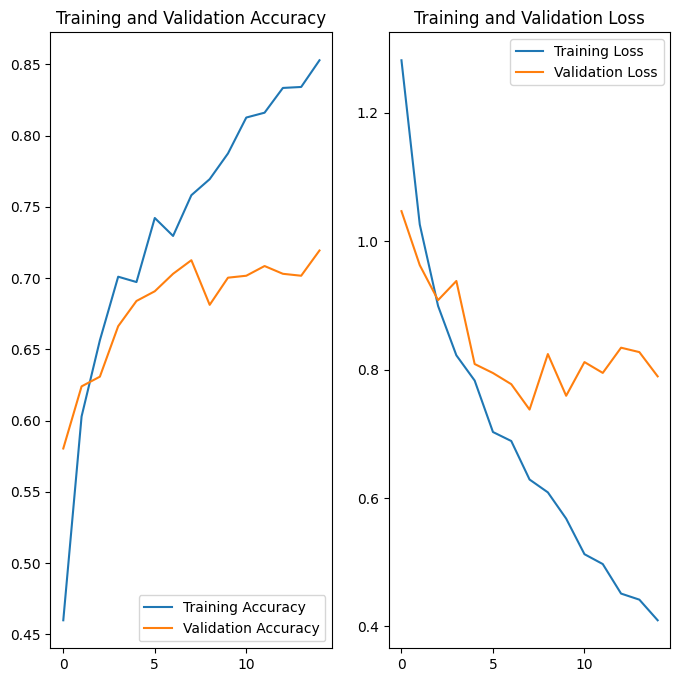

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

117948/117948 [==============================] - 0s 0us/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 114ms/step


This image most likely belongs to sunflowers with a 95.92 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3ntoypci/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp3ntoypci/assets


2022-10-27 01:23:59.635916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-27 01:23:59.635970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 95.92 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.66893e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).